# 03. Нейросети и PyTorch

## План
0. Переопределение `backward` (с прошлого семинара)
1. Готовим обучение
    1. Данные: `Dataset` & `DataLoader` 
    2. Модель: `nn.Module`
    3. Рутина: все остальное
2. Учим
    1. Baseline
    2. Stack more layers
3. I/O
4. Пример с картинками: MNIST

## 0. Переопределение `backward`

Что, если нам хочется релизовать кастомный градиент для произвольной функции.

Зачем?

 - Мы можем знать лучший способ посчитать градиент, чем делать бэкпроп для суперпозиции элементарных функций
 - Можем реализовать численно более устойчивый метод
 - Можем использовать функции из внешних библиотек
 - Использовать недифференцируемые функции?..

Рассмотрим сигмоиду:

$$ 
  \sigma(x) = \frac{1}{1+e^{-x}}
$$

Если честно распишем суперпозицию функций, то получим:

$$
  \sigma(x) = f_1 \odot f_2  \odot f_3 \odot f_4(x), \text{ where }
$$

$$
f_1 = \frac{1}{u}, f_2 = 1 + u, f_3 = \exp(u), f_4 = -u
$$

Тогда:

$$
\frac{\partial \sigma}{\partial x} = \frac{\partial \sigma}{\partial f_1}\frac{\partial f_1}{\partial f_2}\frac{\partial f_2}{\partial f_3}
\frac{\partial f_3}{\partial f_4}
\frac{\partial f_4}{\partial x}
$$

Но зная как устроена производная можно упростить:

$$
\frac{\partial \sigma}{\partial x} = \sigma(x)(1 - \sigma(x))
$$

Вручную задать градиени функции в библиотеке PyTorch можно создав дочерний класс от [`torch.autograd.Function`](https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd).

**Задание:**
Реализуйте `forward()` и `backward()` методы для вычисления сигмоиды.
* Аргумент `grad_output` - это градиент выхода графа по выходу данного слоя, вычисленный в результате backprop.
* Метод `backward()` должен возвращать градиент выхода графа по входу данного слоя.
* `ctx` - переменная контекста, позволяет сохранять значения переменных на `forward`-проходе для их вызова на `backward`-е
    * Для этого у переменной контекста `ctx` есть метод [`save_for_backward()`](https://pytorch.org/docs/stable/generated/torch.autograd.function.FunctionCtx.save_for_backward.html).

In [2]:
import random
import os
import torch
import numpy as np

seed = 123
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.random.manual_seed(seed)
torch.mps.manual_seed(seed)  # torch.cuda.manual_seed(seed)

In [3]:
device = torch.device("cpu")
if torch.has_mps:
    device = torch.device("mps")
elif torch.has_cuda:
    device = torch.device("cuda")
device

/var/folders/4n/f4_hpr8j247_5b18xzd4gqjc0000gn/T/ipykernel_88057/2082989034.py:2: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  if torch.has_mps:


device(type='mps')

In [4]:
from torch.autograd import gradcheck, Function

?Function

Init signature: Function(*args, **kwargs)
Docstring:     
Base class to create custom `autograd.Function`.

To create a custom `autograd.Function`, subclass this class and implement
the :meth:`forward` and :meth:`backward` static methods. Then, to use your custom
op in the forward pass, call the class method ``apply``. Do not call
:meth:`forward` directly.

To ensure correctness and best performance, make sure you are calling the
correct methods on ``ctx`` and validating your backward function using
:func:`torch.autograd.gradcheck`.

See :ref:`extending-autograd` for more details on how to use this class.

Examples::

    >>> # xdoctest: +REQUIRES(env:TORCH_DOCTEST_AUTOGRAD)
    >>> class Exp(Function):
    >>>     @staticmethod
    >>>     def forward(ctx, i):
    >>>         result = i.exp()
    >>>         ctx.save_for_backward(result)
    >>>         return result
    >>>
    >>>     @staticmethod
    >>>     def backward(ctx, grad_output):
    >>>         result, = ctx.saved_tenso

In [5]:
class MySigmoid(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        val = torch.sigmoid(x)
        ctx.save_for_backward(val)
        return val

    @staticmethod
    def backward(ctx, grad_output):
        (val,) = ctx.saved_tensors
        grad = grad_output * val * (1 - val)
        return grad

Pytorch позволяет выполнить сравнение реализованного градиента с градиентом, посчитанным численно:

In [6]:
sigmoid = MySigmoid.apply
x = torch.rand(2, requires_grad=True)
print(gradcheck(sigmoid, x, eps=1e-4, atol=1e-3))

/Users/mkurkin/miniconda3/envs/torch/lib/python3.11/site-packages/torch/autograd/gradcheck.py:920: UserWarning: Input #0 requires gradient and is not a double precision floating point or complex. This check will likely fail if all the inputs are not of double precision floating point or complex. 
  warnings.warn(


True


In [7]:
# be sure to use double for better approximation
x = torch.rand(2, requires_grad=True).double()
print(gradcheck(sigmoid, x, eps=1e-6, atol=1e-4))

True


## 1. Готовим обучение 

Общий подход к решению задачи на pytorch такой:
1. Подготовить данные, реализовать (или использовать готовый) класс `Dataset`, наследуясь от `torch.utils.data.Dataset`, обернуть его в `torch.utils.data.DataLoader`.
2. Реализовать (или взять ±готовую) модель, наследуясь от `nn.Module`.
3. Приготовить оптимизатор для весов модели (из `optim` или свой) и лосс
4. Написать код для рутины обучения, включающий обработку данных из `DataLoader`, прогон их через модель, вычисление лосса и обновление весов оптимизатором.

### 1.1. Данные: `Dataset` & `DataLoader`

* [Tutorial @ pytorch.org](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

Класс датасета предоставит нам интерфейс к данным:
* Метод `__getitem__(self, i)` позволяет получить `i`-й элемент обучающей выборки, обычно пару (data, label).
    * Также обязательным является определение метода `__len__(self)`.
* Можно сделать так, чтобы экземпляр класса датасета просто возвращал исходные данные, а можно (нужно) добавить в него аугментирование данных.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

`Dataset` - абстрактный класс, его нельзя использовать напрямую, а только через наследование:

In [9]:
dataset =Dataset()

In [10]:
dataset[0]

NotImplementedError: Subclasses of Dataset should implement __getitem__.

Создадим датасет поверх игрушечных данных с прошлого семинара:

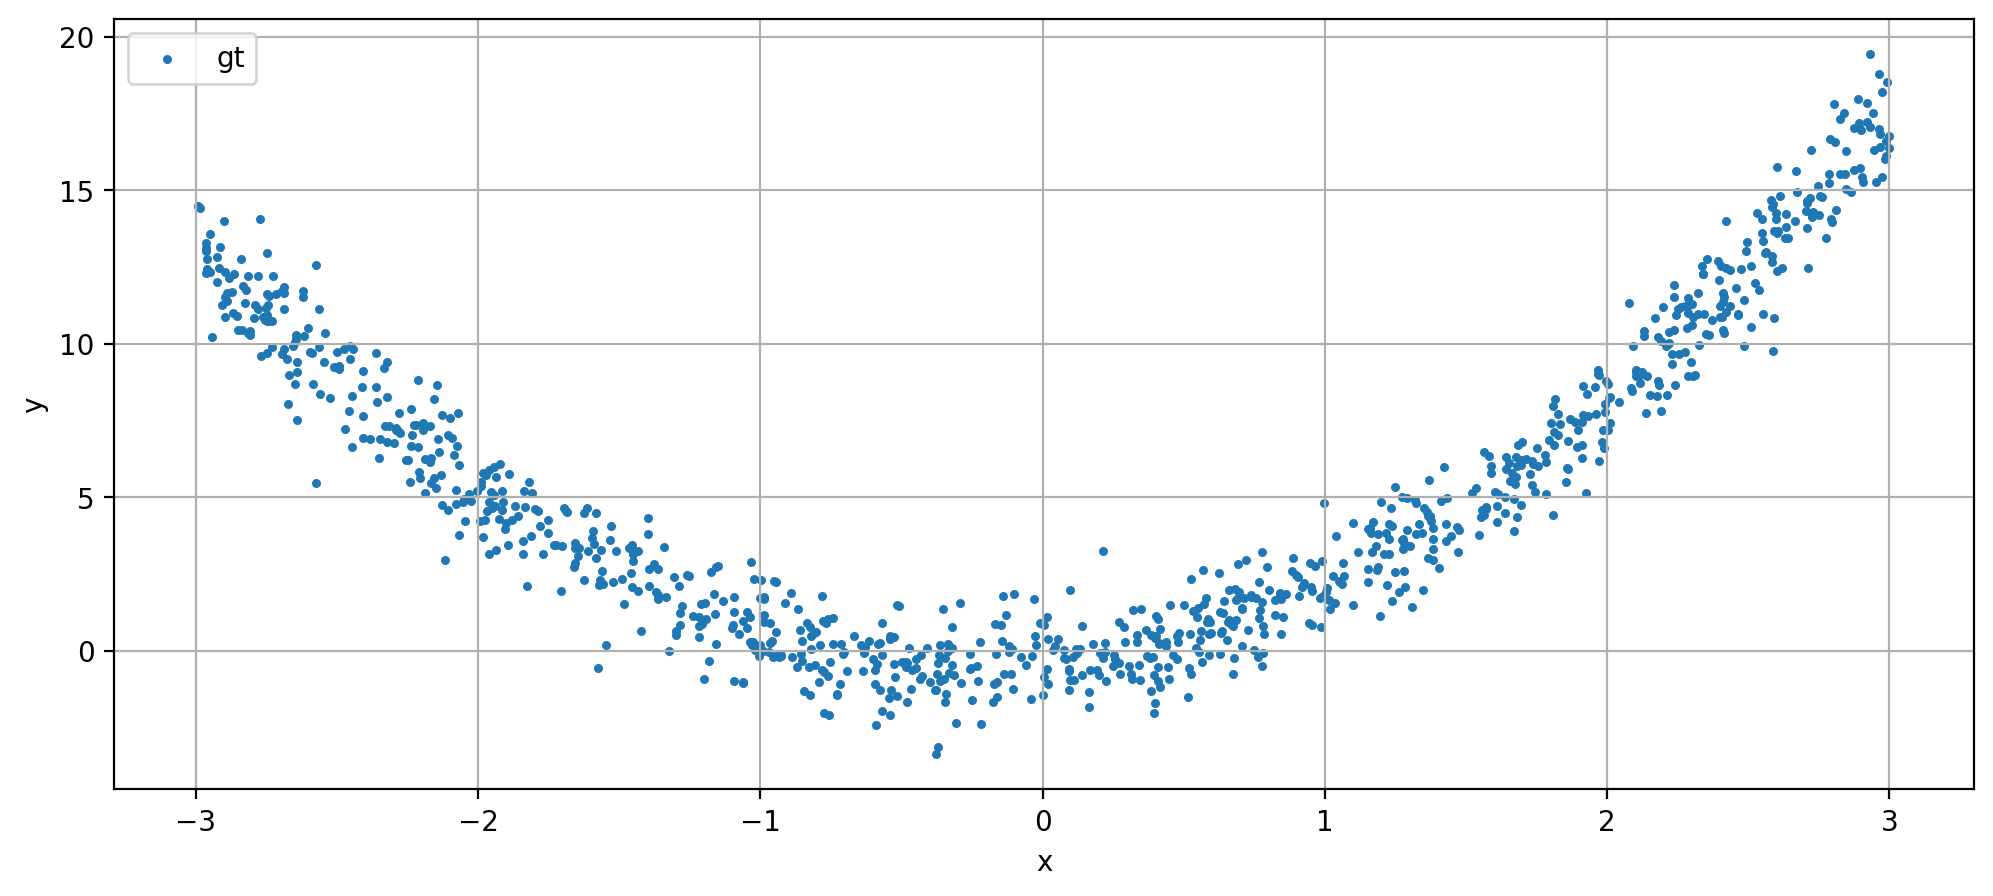

In [11]:
np.random.seed(1234)
_a = np.random.uniform(1, 5)
_b = np.random.uniform(-3, 3)
_c = np.random.uniform(-3, 3)

num_samples = 1000

xs = np.random.uniform(-3, 3, size=num_samples)
ys_clean = _a * xs**2 + _b * xs + _c
ys_noise = np.random.normal(0, 1, size=len(ys_clean))
ys = ys_clean + ys_noise

plt.figure(figsize=(12, 5))
plt.scatter(xs, ys, label="gt", s=5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

In [12]:
class CustomDataset(Dataset):
    def __init__(self, xs, ys):
        super().__init__()

        if len(xs) != len(ys):
            raise ValueError(f"lens mismatch: {len(xs)} != {len(ys)}")

        self.xs = xs
        self.ys = ys

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, i):
        return (self.xs[i], self.ys[i])

    @staticmethod
    def collate_fn(items_list):
        xs = torch.zeros(len(items_list), 1)
        ys = torch.zeros(len(items_list), 1)
        # values = torch.zeros(len(items_list), 2)

        for i, (x, y) in enumerate(items_list):
            xs[i] = x
            ys[i] = y

        return xs, ys

Метод `collate_fn` нужен не столько для самого датасета, сколько для оборачивания его в `DataLoader` - об этом чуть ниже.

In [13]:
dataset = CustomDataset(xs, ys)
dataset[0]

(1.712151502282615, 6.261151337822555)

In [14]:
next(iter(dataset))

(1.712151502282615, 6.261151337822555)

In [15]:
dataset[1]

(1.6798548487128215, 6.005594456243541)

In [16]:
len(dataset)

1000

In [17]:
dataset[100]

(0.34656497056469693, -0.9502726915332733)

По датасету можно итерироваться (но вам это вряд ли будет нужно часто):

In [18]:
for x in dataset[:2]:
    print(x, x.shape)

for x in dataset[:5]:
    print(x, x.shape)

[1.7121515  1.67985485] (2,)
[6.26115134 6.00559446] (2,)
[ 1.7121515   1.67985485 -1.36444437 -1.34121447  1.81123307] (5,)
[6.26115134 6.00559446 1.70076346 3.39949397 6.69226491] (5,)


Теоретически, для обучения достаточно уже объекта типа `Dataset`. Однако, для удобства и для автоматизации процессов перемешивания данных, формирования батчей и использования многопоточности есть удобный класс `DataLoader`:

In [19]:
import os

In [20]:
os.cpu_count() # допустимые значения для num_workers в лоадере

10

In [24]:
dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, drop_last=False, collate_fn=dataset.collate_fn)

"Длина" даталоадера - это количество батчей:

In [22]:
len(dataloader)

32

К даталоадеру нельзя обращаться по индексу, но можно итерироваться по нему:

In [23]:
dataloader[81231231]

TypeError: 'DataLoader' object is not subscriptable

In [25]:
print([tensor.shape for tensor in next(iter(dataloader))])

[torch.Size([32, 1]), torch.Size([32, 1])]


In [26]:
for batch in dataloader:
    xs, ys = batch
    print(xs.shape, ys.shape)
    break

torch.Size([32, 1]) torch.Size([32, 1])


Как именно происходит сборка батчей, покажем, реализовав свой игрушечный даталоадер с аналогичным функционалом:

**Задание**:
Реализовать метод `__getitem__(self, i)`, который должен возвращать i-й батч. 
* Батч должен быть списком с числом элементов = равным числу элементов, возвращаемых датасетом при обращении по индексу (обычно 2 - данные и лейблы, но есть варианты).
    * Каждый из элементов содержит не отдельный объект, а склеенный из отдельных объектов тензов
    * Длина каждого = `batch_size`
* Для сборки батча из отдельных элементов датасета используйте метод `self.dataset.collate_fn`

In [27]:
class MyDataLoader:
    def __init__(self, dataset, batch_size, collate_fn):
        self.dataset = dataset
        self.batch_size = batch_size
        self.collate_fn = collate_fn

        self.indices = np.arange(len(dataset))

    def __len__(self):
        return len(dataset) // self.batch_size

    def __getitem__(self, i):
        # YOUR CODE HERE

        # indices = ...
        # items = ...
        # batch = ...
        
        indices = self.indices[i * self.batch_size: (i + 1) * self.batch_size]
        items = [self.dataset[i] for i in indices]
        batch = self.collate_fn(items)
        # END OF YOUR CODE

        return batch

In [28]:
my_dataloader = MyDataLoader(dataset, batch_size=32, collate_fn=dataset.collate_fn)

In [29]:
batch = my_dataloader[0]

assert len(batch) == 2
assert batch[0].shape == (32, 1)
assert batch[1].shape == (32, 1)

Про параметры `DataLoader`-а, которые мы сегодня не трогали (`pin_memory`, `num_workers`, ...), поговорим в другой раз.

### 1.2. Модель: `nn.Module`

Нейросетевые модели состоят из слоев, которые применяются ко входу (обычно) последовательно.
Каждый слой должен быть наследником `nn.Module`, чтобы сам pytorch понимал: перед ним слой нейросети, у него есть параметры, его надо уметь дифференцировать, и т.д.

In [30]:
import torch.nn as nn

**Задание:**
Реализовать недостающие куски кода в методах `__init__()` и `forward()`.
* В `__init__()` должны быть инициализированы матрица `self.weights` (`out_dim x in_dim`) и вектор `bias` (или `None`).
* В `forward()` они должны быть применены ко входу `x` (`batch x in_dim`).

**NB**: Помните, что обычно обработка данных моделью происходит по батчам, т.е. даже если на вход придет 1 объект, у него будет размерность (`batch x in_dim`).

В чём принципиальное отличие `nn.Module` от `autograd.Function`? ООП и переиспользование функций с реализованным дифференцированием.

In [31]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()

        # YOUR CODE HERE

        # self.weight = ...
        # self.bias = ...
        self.weight = nn.Parameter(torch.randn(out_features, in_features) / torch.sqrt(torch.tensor(in_features, dtype=torch.float32)))
        # self.weight = nn.Parameter()
        self.bias = nn.Parameter(torch.randn(out_features))
        # END OF YOUR CODE

    def forward(self, x):
        # YOUR CODE HERE

        # output = ...
        output = x @ self.weight.T # (B, in_features) x (out_features, in_features).T
        output = output + self.bias
        # END OF YOUR CODE

        return output

    def __repr__(self):
        return f"CustomLinear({self.weight.shape[1]}, {self.weight.shape[0]}, bias={self.bias is not None})"

In [32]:
linear = CustomLinear(8, 1)

batch_size = 5
x = torch.randn(batch_size, 8)

linear(x)

tensor([[ 0.2791],
        [-0.3815],
        [-0.7465],
        [ 0.8459],
        [ 0.3910]], grad_fn=<AddBackward0>)

In [33]:
linear = CustomLinear(8, 1)

assert isinstance(linear.weight, nn.Parameter)
assert isinstance(linear.bias, nn.Parameter)
assert linear.weight.shape == (1, 8)
assert linear.bias.shape == (1,)

In [34]:
print(linear)

CustomLinear(8, 1, bias=True)


In [35]:
dir(nn.Module)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_call_impl',
 '_compiled_call_impl',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_maybe_warn_non_full_backward_hook',
 '_named_members',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_version',
 '_wrapped_call_impl',
 'add_module',
 'apply',
 'bfloat16',
 'buffers',
 'call_super_init',
 'children',
 'compile',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',


In [36]:
linear.requires_grad_(False) # подвергаются тензоры весов в nn.Parameter

CustomLinear(8, 1, bias=True)

Посмотрим, какие атрибуты и методы есть у нашего класса при наследовании от `nn.Module`.

Во-первых, доступ к обучаемым (и не только) параметрам:

In [37]:
for p in linear.parameters():
    print(p)
    print()

Parameter containing:
tensor([[ 0.3439,  0.2481,  0.7827, -0.0098,  0.3727,  0.2001, -0.1350,  0.3114]])

Parameter containing:
tensor([0.2710])



In [38]:
for p in linear.named_parameters():
    print(p)
    print()

('weight', Parameter containing:
tensor([[ 0.3439,  0.2481,  0.7827, -0.0098,  0.3727,  0.2001, -0.1350,  0.3114]]))

('bias', Parameter containing:
tensor([0.2710]))



In [39]:
linear.state_dict()

OrderedDict([('weight',
              tensor([[ 0.3439,  0.2481,  0.7827, -0.0098,  0.3727,  0.2001, -0.1350,  0.3114]])),
             ('bias', tensor([0.2710]))])

Для удобства чтения и отладки, часто полезно определить dunder-метод `__repr__` для информативного вывода самого объекта:

In [40]:
print(linear)

CustomLinear(8, 1, bias=True)


Важными полями являются индикатор `.training`: он показывает, в каком режиме находится модель - обучения или инференса.

**Вопрос**: зачем?

In [41]:
linear.training

True

In [42]:
linear.eval()
linear.training

False

In [43]:
linear.train()
linear.training

True

**NB**: Выход из режима `training` не отключает вычисление градиентов!

Как мы уже говорили в прошлый раз, вычисления можно производить не только в одиночной точности; для этого необходимо (но не всегда достаточно) привести все веса к соответствующему типу. Наследование от класса `nn.Module` позволяет сделать это одной командой:

In [44]:
linear.weight.device, linear.bias.device

(device(type='cpu'), device(type='cpu'))

In [45]:
linear.weight.dtype

torch.float32

In [46]:
linear = linear.half()

In [47]:
linear.weight.dtype

torch.float16

In [48]:
linear = linear.float()

In [49]:
linear.weight.dtype

torch.float32

In [50]:
linear = linear.to(device=device, dtype=torch.bfloat16)

In [51]:
linear.weight.dtype, linear.weight.device

(torch.bfloat16, device(type='mps', index=0))

А вот что pytorch из коробки делать не позволяет, так это узнать, на каком устройстве лежит наша модель:

In [52]:
device = torch.device("mps")

In [53]:
# device = torch.device("cpu")
device = torch.device("mps")

In [54]:
linear = linear.to(device)

In [55]:
linear.device

AttributeError: 'CustomLinear' object has no attribute 'device'

In [56]:
linear.weight.device

device(type='mps', index=0)

In [57]:
next(linear.parameters()).device

device(type='mps', index=0)

In [58]:
device = torch.device("cpu")

In [59]:
linear = linear.to(device)

Теперь попробуем собственно применить нашу модель:

In [60]:
x = torch.randn(32, 8)

In [61]:
linear = linear.to(dtype=torch.float32)

In [62]:
y = linear(x)
y.shape

torch.Size([32, 1])

In [63]:
x = torch.randn(32, 9)
y = linear(x)
y.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x9 and 8x1)

### 1.3. Рутина: все остальное

#### 1.3.1. Оптимизатор

In [64]:
import torch.optim as optim

In [66]:
linear = CustomLinear(8, 1)

In [67]:
param_groups = list(linear.named_parameters())
param_groups = [{"lr": 1e-3, "params": param_groups[0][1]}, {"params": param_groups[1][1]}]

In [68]:
param_groups

[{'lr': 0.001,
  'params': Parameter containing:
  tensor([[-0.0605, -0.1343, -0.1904, -0.3361, -0.3958,  0.0011, -0.6930,  0.0465]],
         requires_grad=True)},
 {'params': Parameter containing:
  tensor([0.3920], requires_grad=True)}]

In [69]:
optimizer = optim.SGD(
    param_groups,
    lr=1e-4
)

In [70]:
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [71]:
optimizer.param_groups

[{'lr': 0.001,
  'params': [Parameter containing:
   tensor([[-0.0605, -0.1343, -0.1904, -0.3361, -0.3958,  0.0011, -0.6930,  0.0465]],
          requires_grad=True)],
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False,
  'fused': None},
 {'params': [Parameter containing:
   tensor([0.3920], requires_grad=True)],
  'lr': 0.0001,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False,
  'fused': None}]

#### 1.3.2. Лосс

Можно написать самому:

In [72]:
def mse_loss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

In [73]:
xs, ys_true = next(iter(dataloader))

In [74]:
ys_pred = torch.randn_like(ys_true)

In [75]:
mse_loss(ys_true, ys_pred)

tensor(48.3778)

Можно использовать готовые:

In [76]:
from torch.nn.functional import mse_loss as torch_mse_loss

In [77]:
torch_mse_loss(ys_true, ys_pred)

tensor(48.3778)

#### 1.3.3. Рутина обучения

**Задание:** Дописать функцию для обучения.
* Получение предсказаний моделью для объектов из батча
* Подсчет лосса
* Обновление весов по вызова backprop

In [78]:
def train_epoch(model, dataloader, optimizer, loss_fn, epoch):
    model.train()

    losses = []
    for batch in dataloader:
        xs, ys_true = batch
        xs = xs.to(device)
        ys_true = ys_true.to(device)

        # YOUR CODE HERE

        # ys_pred = ...
        # loss = ...
        # ...
        # ...
        ys_pred = model(xs)
        loss = loss_fn(ys_pred, ys_true)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # END OF YOUR CODE

        losses.append(loss.item())

    return np.mean(losses)

На валидации будем еще и сохранять результат предсказаний - для визуализации:

In [79]:
@torch.inference_mode()
def val_epoch(model, dataloader, loss_fn):
    model.eval()

    losses = []
    preds = []
    for batch in dataloader:
        xs, ys_true = batch
        xs = xs.to(device)
        ys_true = ys_true.to(device)
        # with torch.no_grad():
        #     ys_pred = model(xs)
        ys_pred = model(xs)

        loss = loss_fn(ys_pred, ys_true)
        losses.append(loss.item())

        preds.append(ys_pred.detach().cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    return np.mean(losses), preds

## 2. Учим

### 2.1. Baseline

Начнем с обучения 1 полносвязного слоя, по сути - аппроксимируем данные прямой.

In [80]:
import tqdm

In [81]:
num_epochs = 128
lr = 8e-4
batch_size = 8

train_size = 800

In [82]:
xs = np.random.uniform(-3, 3, size=num_samples)
ys_clean = _a * xs**2 + _b * xs + _c
ys_noise = np.random.normal(0, 1, size=len(ys_clean))
ys = ys_clean + ys_noise

train_dataset = CustomDataset(xs[:train_size], ys[:train_size])
val_dataset = CustomDataset(xs[train_size:], ys[train_size:])

In [83]:
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True
)

val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=train_dataset.collate_fn, drop_last=False
)

In [84]:
device = torch.device("cpu")

In [85]:
model = CustomLinear(1, 1).to(device)

In [86]:
optimizer = optim.SGD(model.parameters(), lr=lr)

In [87]:
loss_fn = mse_loss

In [88]:
losses = []
val_losses = []
val_preds = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)

    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)
    val_preds.append(preds)

100%|██████████| 128/128 [00:02<00:00, 55.76it/s]


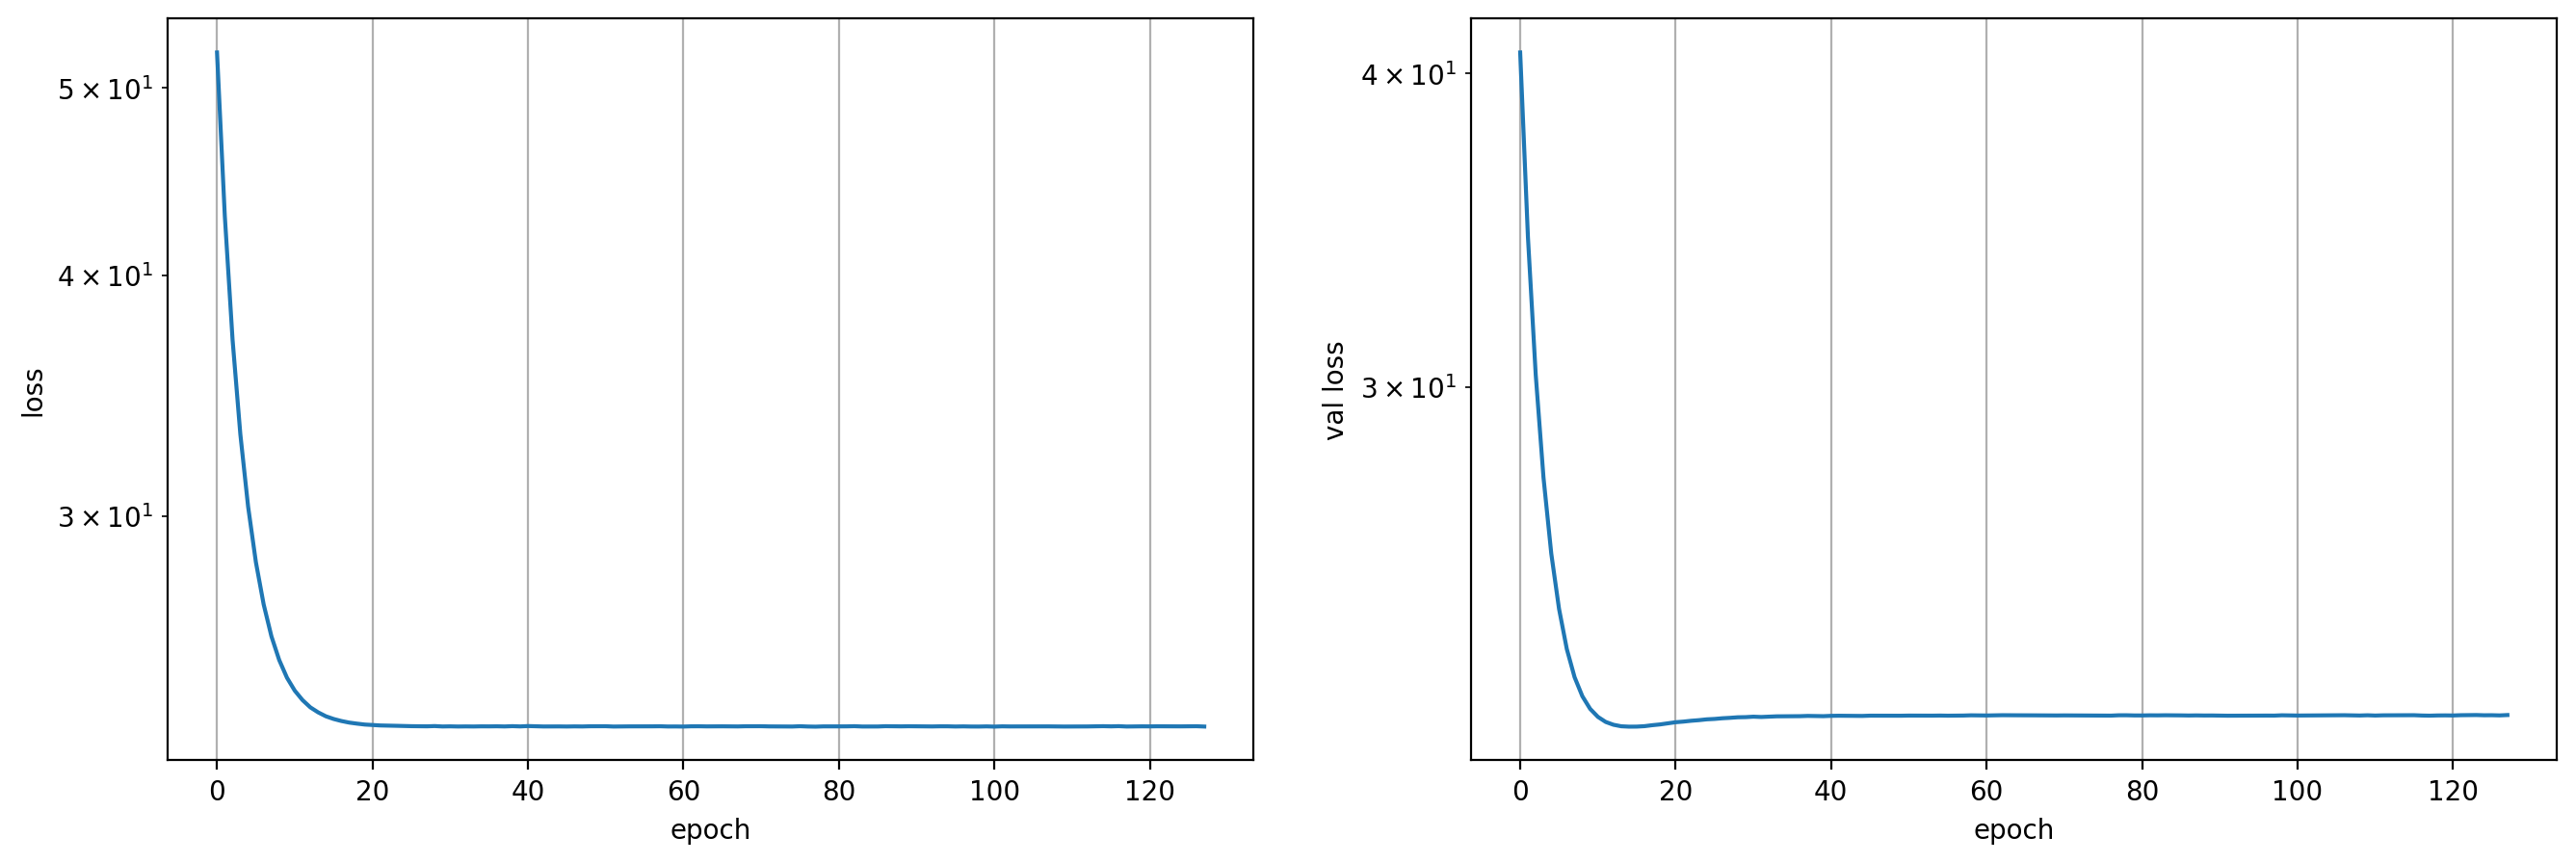

In [89]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.semilogy(losses)
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.semilogy(val_losses)
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("val loss")

plt.show()

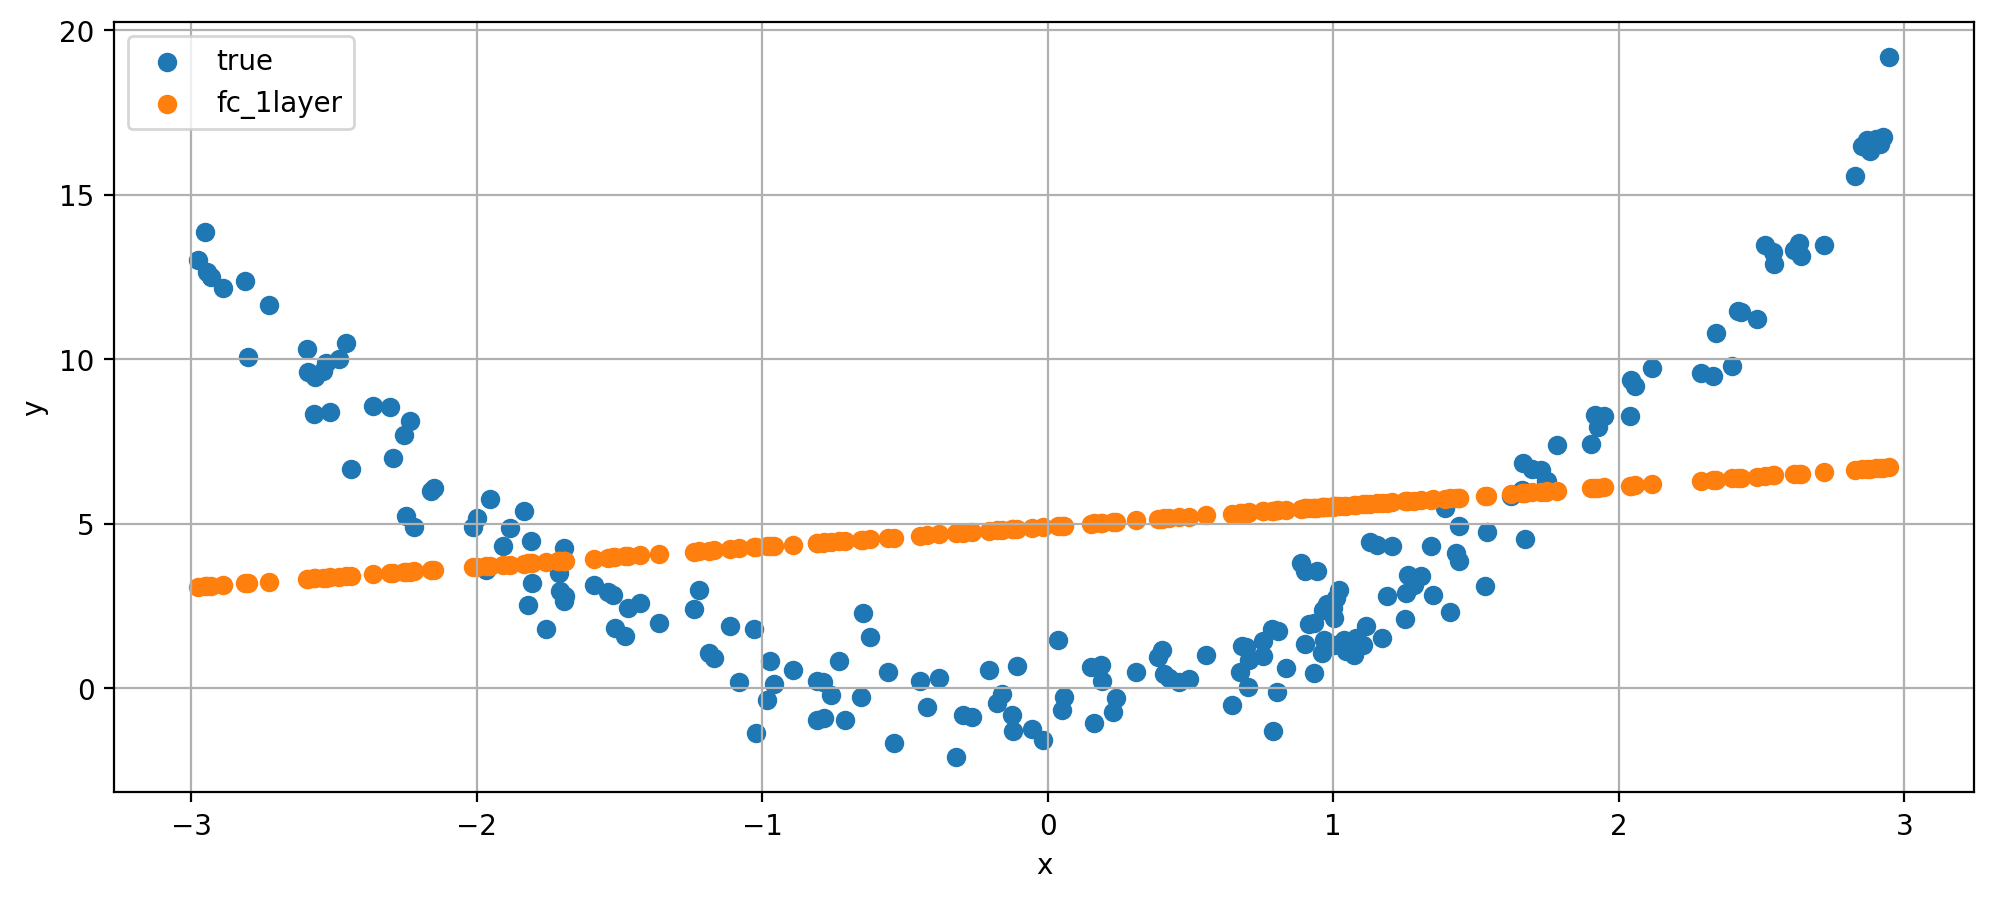

In [90]:
plt.figure(figsize=(12, 5))
plt.scatter(xs[train_size:], ys[train_size:], label="true")
plt.scatter(xs[train_size:], val_preds[-1], label="fc_1layer")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [91]:
fc_1layer_train_losses = losses
fc_1layer_val_losses = val_losses
fc_1layer_preds = preds

### 2.2. Stack more layers

In [92]:
from torch.nn import Sequential
from torch.nn import ReLU

**Задание**: соберите сеть из двух полносвязных слоев размерами (1, 4) и (4, 1); добавьте между слоями нелинейность ReLU.

In [93]:
# YOUR CODE HERE
# model = ...
# END OF YOUR CODE

model = nn.Sequential(
    CustomLinear(1, 4),
    nn.ReLU(inplace=True), # так сохраняем память на backward-е
    CustomLinear(4, 1)
)

In [94]:
optimizer = optim.SGD(model.parameters(), lr=lr)

In [95]:
losses = []
val_losses = []
val_preds = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)

    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)
    val_preds.append(preds)

100%|██████████| 128/128 [00:02<00:00, 43.11it/s]


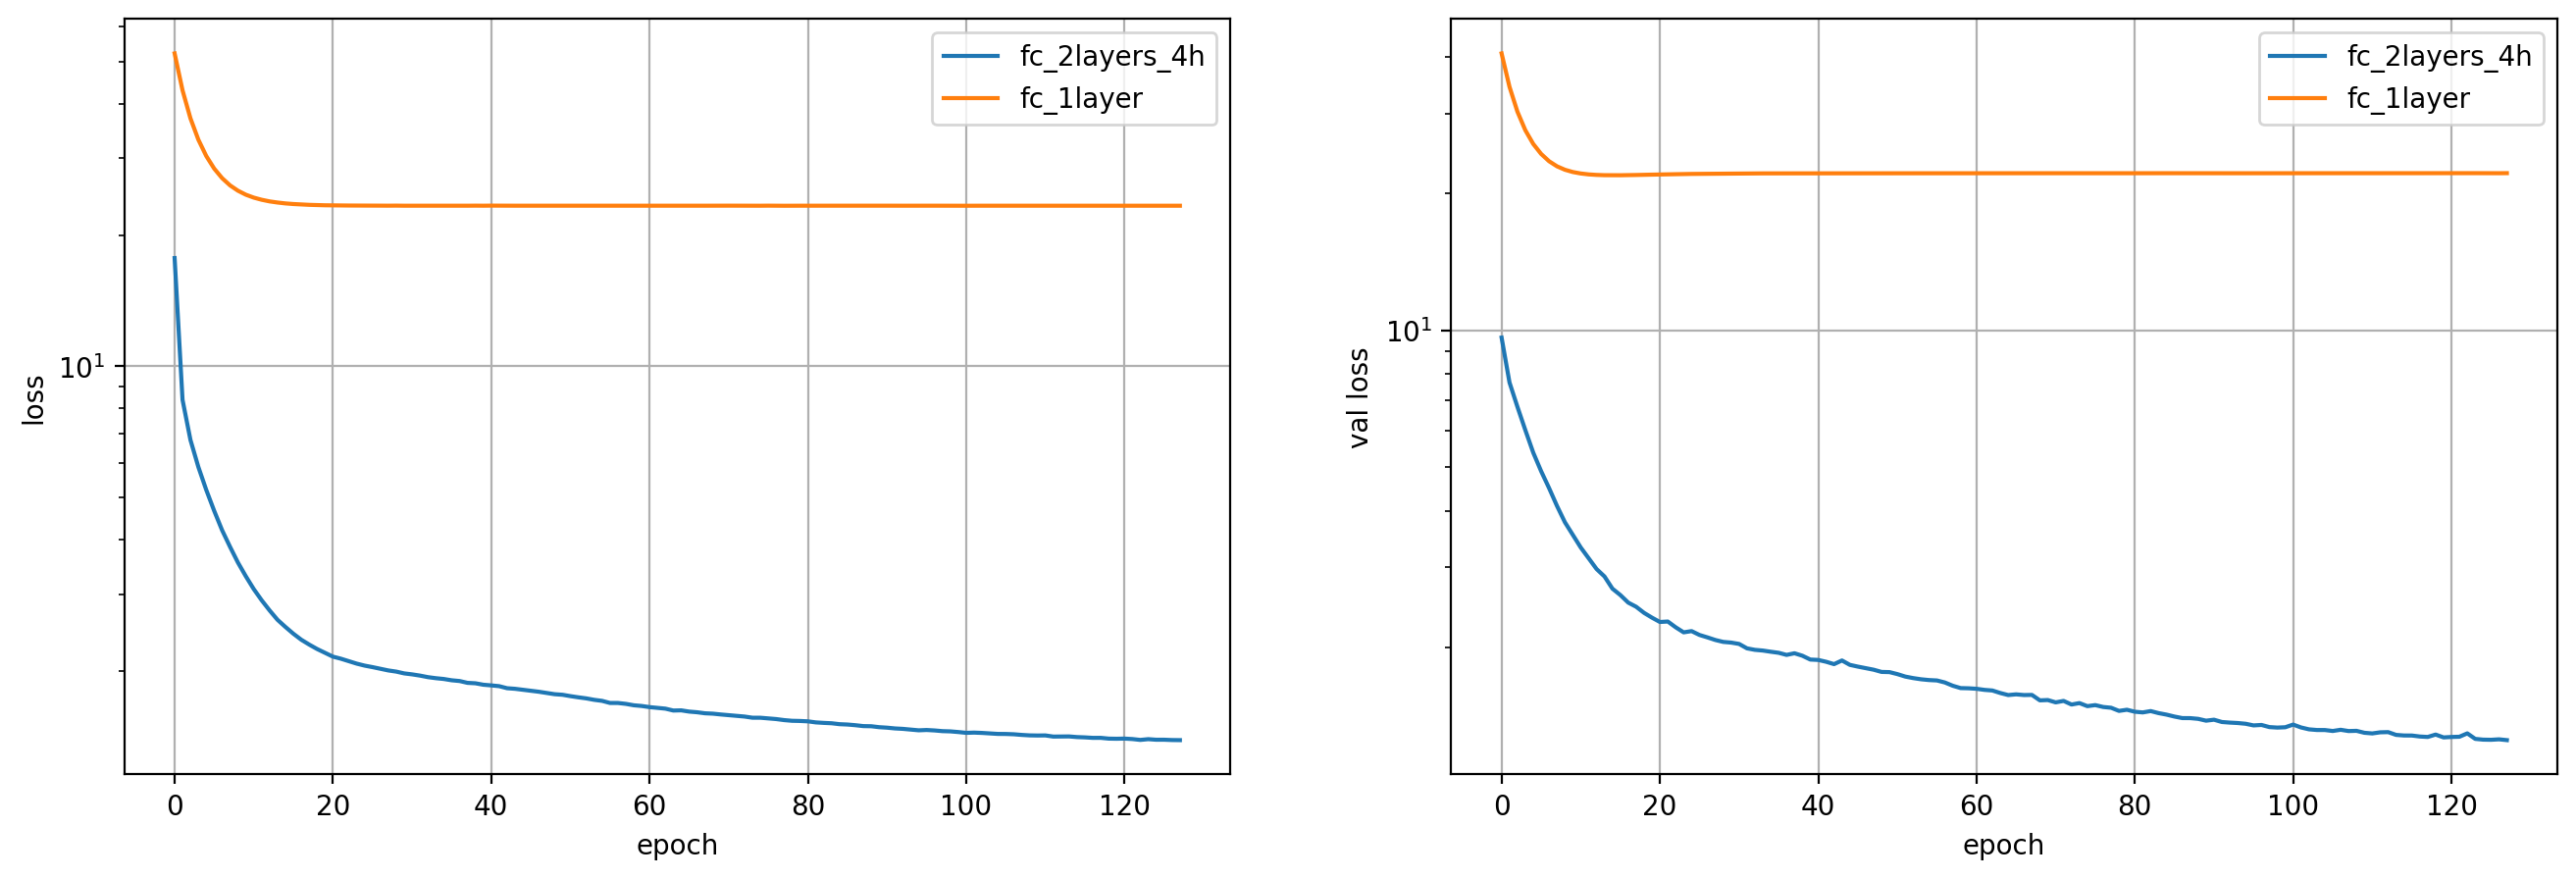

In [96]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.semilogy(losses, label="fc_2layers_4h")
plt.semilogy(fc_1layer_train_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.semilogy(val_losses, label="fc_2layers_4h")
plt.semilogy(fc_1layer_val_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("val loss")

plt.show()

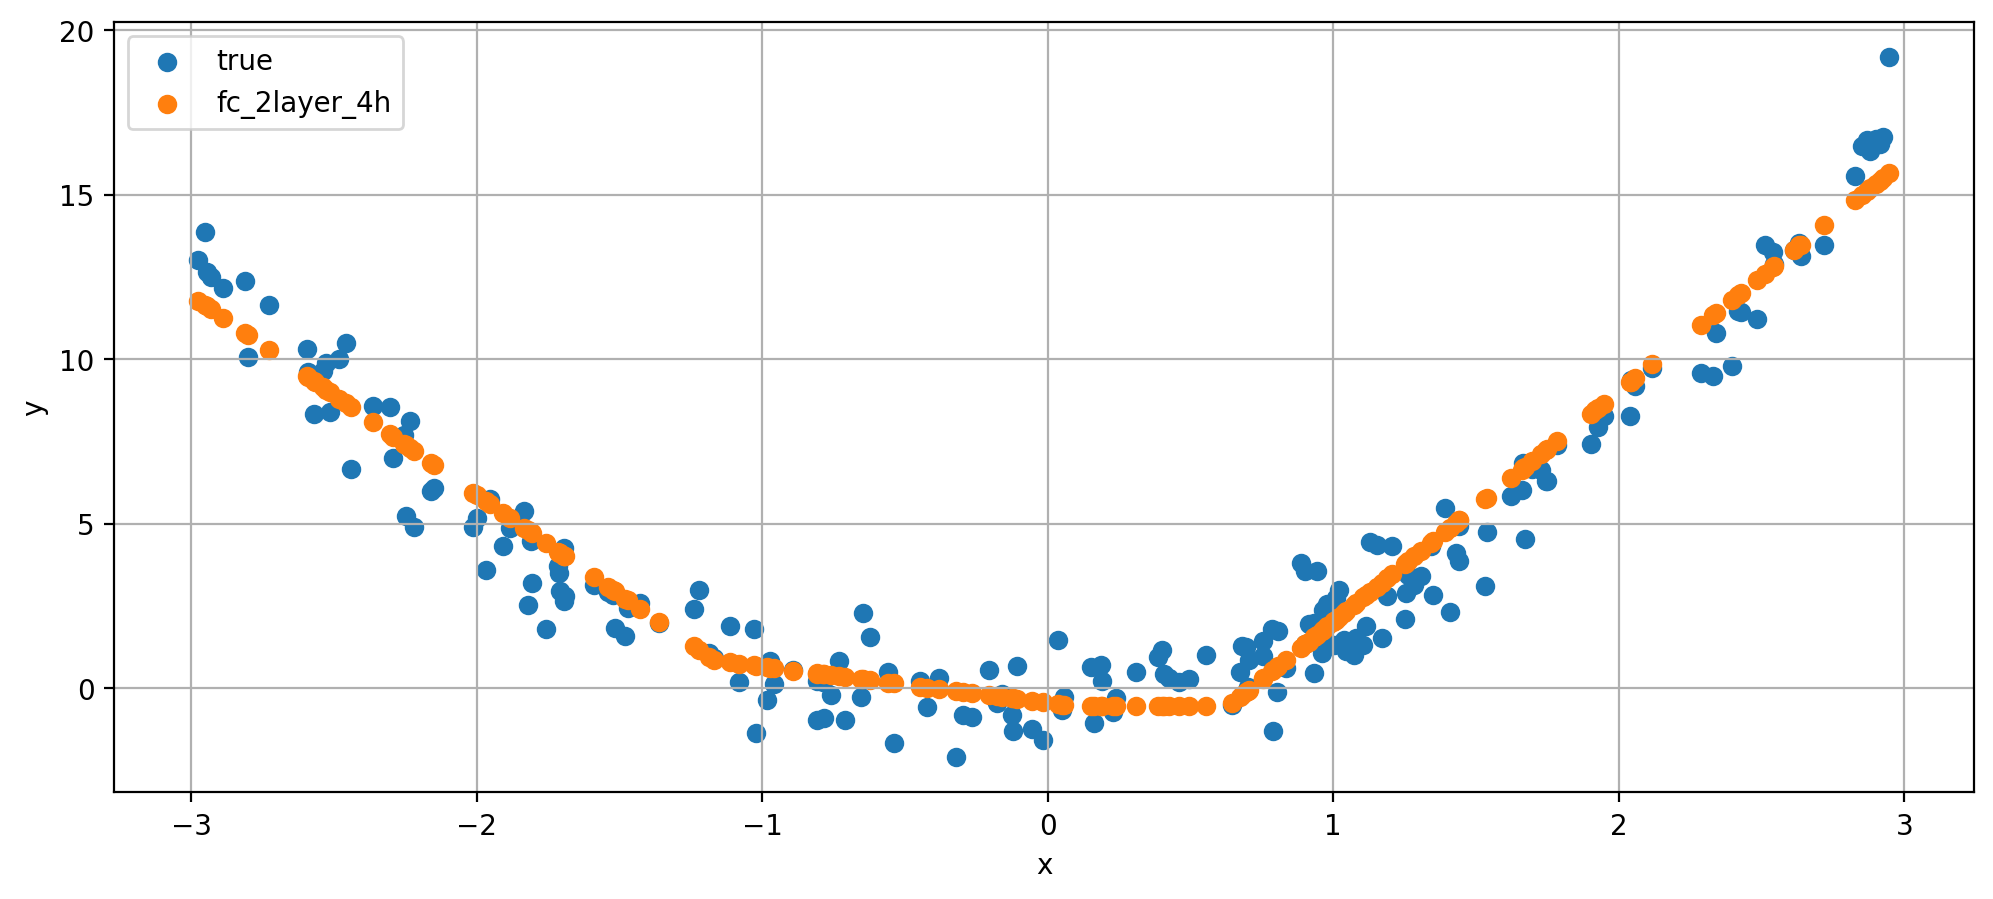

In [97]:
plt.figure(figsize=(12, 5))
plt.scatter(xs[train_size:], ys[train_size:], label="true")
plt.scatter(xs[train_size:], val_preds[-1], label="fc_2layer_4h")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [98]:
fc_2layer_4h_train_losses = losses
fc_2layer_4h_val_losses = val_losses
fc_2layer_4h_preds = preds

Добавим нейронов в скрытый слой:

In [99]:
layers = [CustomLinear(1, 16), ReLU(inplace=True), CustomLinear(16, 1)]

model = Sequential(*layers)
model

Sequential(
  (0): CustomLinear(1, 16, bias=True)
  (1): ReLU(inplace=True)
  (2): CustomLinear(16, 1, bias=True)
)

In [100]:
optimizer = optim.SGD(model.parameters(), lr=lr)

In [101]:
losses = []
val_losses = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)

    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)

100%|██████████| 128/128 [00:02<00:00, 44.88it/s]


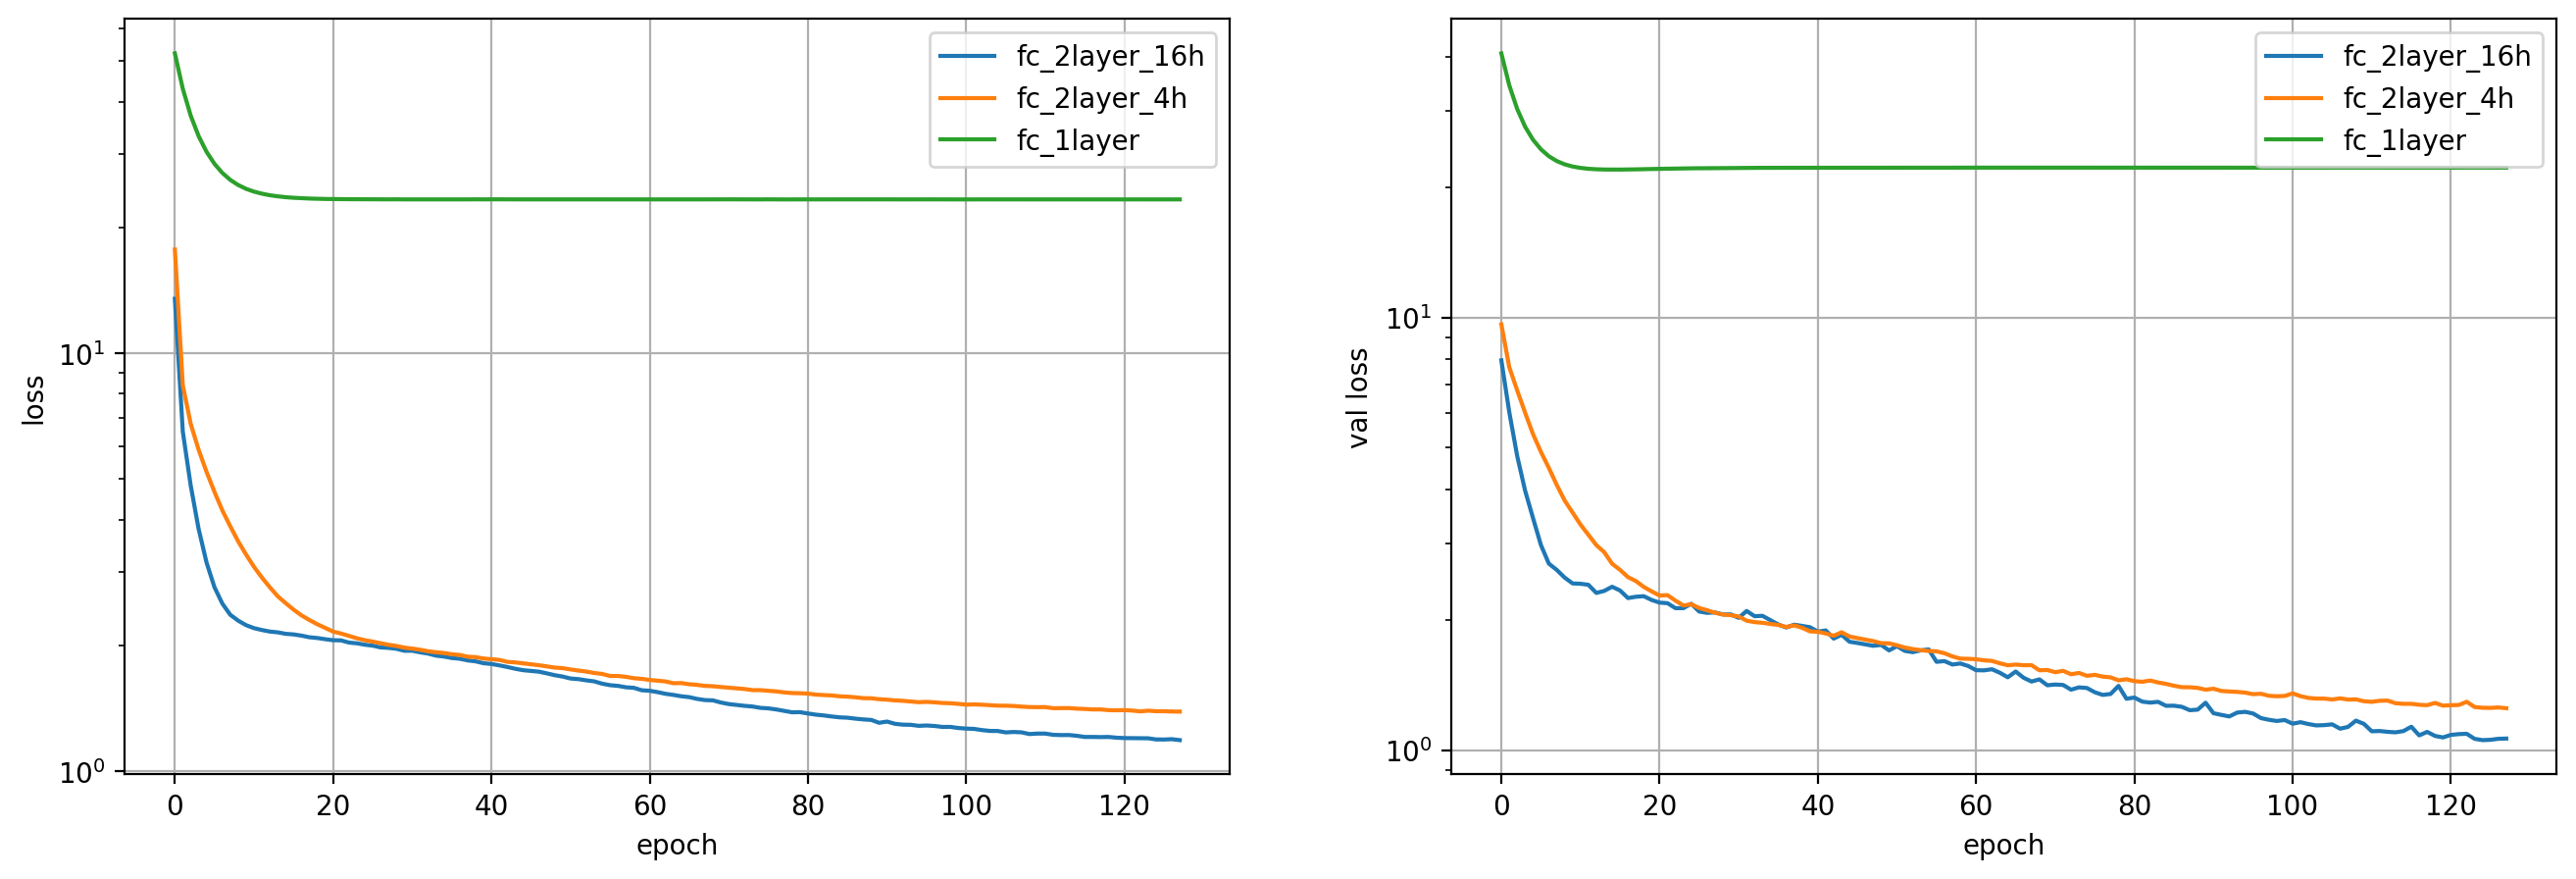

In [102]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.semilogy(losses, label="fc_2layer_16h")
plt.semilogy(fc_2layer_4h_train_losses, label="fc_2layer_4h")
plt.semilogy(fc_1layer_train_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.semilogy(val_losses, label="fc_2layer_16h")
plt.semilogy(fc_2layer_4h_val_losses, label="fc_2layer_4h")
plt.semilogy(fc_1layer_val_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("val loss")

plt.show()

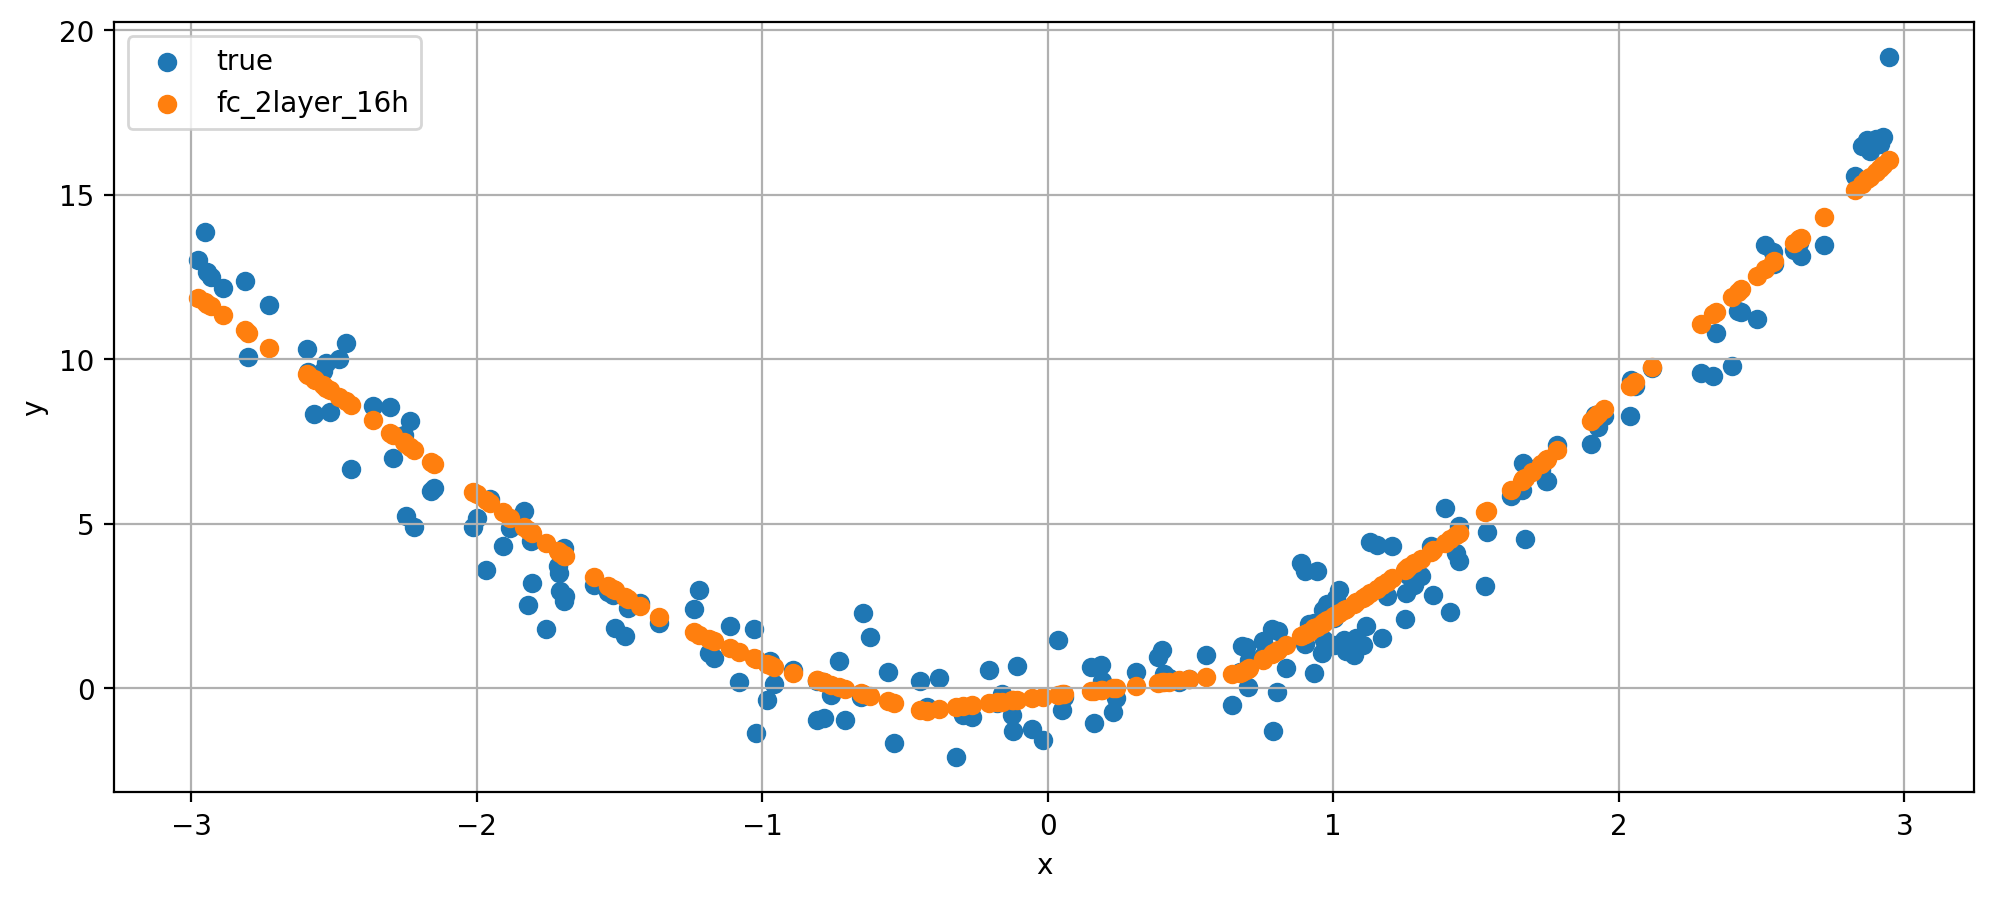

In [104]:
plt.figure(figsize=(12, 5))
plt.scatter(xs[train_size:], ys[train_size:], label="true")
plt.scatter(xs[train_size:], preds, label="fc_2layer_16h")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Видимо, что наша модель ведет себя как кусочно-линейная функция. Любопытные визуализации на эту тему можно найти, например, [здесь](http://neuralnetworksanddeeplearning.com/chap4.htmlhttp://neuralnetworksanddeeplearning.com/chap4.html).

**Пища для размышлений:** данные были сгенерированы с использованием всего лишь трех неизвестных параметров (a, b, c). Они полностью, не считая случайного шума, определяют поведение целевой функции. Нам же потребовалось значительно больше параметров (сколько, кстати?), чтобы кое-как аппроксимировать данные с помощью полносвязной сети. Почему это так? Можно ли с этим что-то сделать?
См. [Yarotsky Bound](https://arxiv.org/abs/1610.01145) как ответ на вопрос об оптимальной аппроксимации квадратичной функции и исследования по [Scaling Laws](https://arxiv.org/abs/2001.08361).

## 3. I/O

Обученные веса модели хорошо бы уметь сохранять и загружать для дальнейшего использования.

In [105]:
print(model)

Sequential(
  (0): CustomLinear(1, 16, bias=True)
  (1): ReLU(inplace=True)
  (2): CustomLinear(16, 1, bias=True)
)


В Pytorch сохранение и загрузка весов выполняется через `state_dict` модели:

In [106]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[-0.9733],
        [-2.1640],
        [ 0.2361],
        [-1.0534],
        [-0.7325],
        [ 0.0315],
        [-0.6194],
        [-0.7030],
        [ 0.3328],
        [-0.6013],
        [-0.4220],
        [ 0.8659],
        [ 0.0939],
        [-0.5053],
        [ 2.2597],
        [ 1.5015]])), ('0.bias', tensor([ 1.4314, -0.9186,  0.0578, -0.9931,  0.7801, -0.0968, -0.8378, -1.0994,
        -0.5350,  2.2054,  1.8972,  0.4281,  0.3853, -1.5162, -1.5276,  2.0857])), ('2.weight', tensor([[ 1.5699,  1.3047, -0.0291,  1.1117,  0.8009, -0.2305,  0.8723,  0.8029,
          0.5569, -1.0385, -1.1946,  0.9146, -0.3621, -0.3687,  1.8703,  0.8549]])), ('2.bias', tensor([-0.5982]))])


### 3.1. Save

In [107]:
output_fn = "./state_dict.pth.tar"

In [108]:
with open(output_fn, "wb") as fp:
    torch.save(model.state_dict(), fp)

### 3.2. Load

In [109]:
model = Sequential(CustomLinear(1, 16), ReLU(inplace=True), CustomLinear(16, 1))

In [110]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[-1.3089],
        [-0.4094],
        [ 0.0134],
        [-0.3722],
        [ 0.2945],
        [ 0.3691],
        [-0.0239],
        [ 2.2092],
        [-0.1904],
        [-0.5065],
        [ 0.5802],
        [-0.3505],
        [ 0.9134],
        [-0.5405],
        [-0.0296],
        [ 0.6059]])), ('0.bias', tensor([ 0.5796, -0.3348,  1.8503, -1.1150,  1.0423,  1.1551, -0.7901,  0.0266,
         0.2427,  0.4463, -0.1622,  0.0722,  0.7711, -0.2716,  0.3270, -0.8700])), ('2.weight', tensor([[-0.0580,  0.0761, -0.2766,  0.3466,  0.6050, -0.2263,  0.0996,  0.0483,
         -0.2337,  0.1939, -0.4809,  0.0718, -0.0676, -0.0950,  0.0713, -0.0555]])), ('2.bias', tensor([-0.7722]))])


In [111]:
with open(output_fn, "rb") as fp:
    state_dict = torch.load(fp, map_location="cpu", )
state_dict

/var/folders/4n/f4_hpr8j247_5b18xzd4gqjc0000gn/T/ipykernel_88057/430348479.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fp, map_location="cpu"

OrderedDict([('0.weight',
              tensor([[-0.9733],
                      [-2.1640],
                      [ 0.2361],
                      [-1.0534],
                      [-0.7325],
                      [ 0.0315],
                      [-0.6194],
                      [-0.7030],
                      [ 0.3328],
                      [-0.6013],
                      [-0.4220],
                      [ 0.8659],
                      [ 0.0939],
                      [-0.5053],
                      [ 2.2597],
                      [ 1.5015]])),
             ('0.bias',
              tensor([ 1.4314, -0.9186,  0.0578, -0.9931,  0.7801, -0.0968, -0.8378, -1.0994,
                      -0.5350,  2.2054,  1.8972,  0.4281,  0.3853, -1.5162, -1.5276,  2.0857])),
             ('2.weight',
              tensor([[ 1.5699,  1.3047, -0.0291,  1.1117,  0.8009, -0.2305,  0.8723,  0.8029,
                        0.5569, -1.0385, -1.1946,  0.9146, -0.3621, -0.3687,  1.8703,  0.8549]])),
        

In [112]:
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [113]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.9733],
                      [-2.1640],
                      [ 0.2361],
                      [-1.0534],
                      [-0.7325],
                      [ 0.0315],
                      [-0.6194],
                      [-0.7030],
                      [ 0.3328],
                      [-0.6013],
                      [-0.4220],
                      [ 0.8659],
                      [ 0.0939],
                      [-0.5053],
                      [ 2.2597],
                      [ 1.5015]])),
             ('0.bias',
              tensor([ 1.4314, -0.9186,  0.0578, -0.9931,  0.7801, -0.0968, -0.8378, -1.0994,
                      -0.5350,  2.2054,  1.8972,  0.4281,  0.3853, -1.5162, -1.5276,  2.0857])),
             ('2.weight',
              tensor([[ 1.5699,  1.3047, -0.0291,  1.1117,  0.8009, -0.2305,  0.8723,  0.8029,
                        0.5569, -1.0385, -1.1946,  0.9146, -0.3621, -0.3687,  1.8703,  0.8549]])),
        

Помимо непосредственно весов, бывает полезно сохранить и состояние других объектов: например, оптимизатора (чтобы продолжить обучении с той же точки):

In [114]:
def save_checkpoint(model, optimizer, output_fn):
    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}

    with open(output_fn, "wb") as fp:
        torch.save(checkpoint, output_fn)


def load_checkpoint(checkpoint_fn, model, optimizer):
    with open(checkpoint_fn, "rb") as fp:
        checkpoint = torch.load(fp, map_location="cpu")

    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [115]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
optimizer.param_groups[0]["lr"] = 1e-10
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-10
    maximize: False
    weight_decay: 0
)

In [116]:
checkpoint_fn = "./checkpoint.pth.tar"

In [117]:
save_checkpoint(model, optimizer, checkpoint_fn)

In [118]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

In [119]:
load_checkpoint(checkpoint_fn, model, optimizer)

/var/folders/4n/f4_hpr8j247_5b18xzd4gqjc0000gn/T/ipykernel_88057/2563314619.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location="cp

In [120]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-10
    maximize: False
    weight_decay: 0
)

## 4. Пример с картинками: MNIST

Обучения на MNIST в курсе DL почти не избежать...

In [121]:
import os
import glob
import matplotlib.pyplot as plt

In [122]:
#!pip install opencv-python

In [123]:
import cv2

MNIST - это ставший классикой датасет с изображениями рукописных цифр. На нем мы построим минимальный пример работы с изображениями.

Вообще он есть в `torchvision.datasets.MNIST`, но сегодня для наглядности мы обработаем его самописным классом.

In [124]:
import torchvision

?torchvision.datasets.MNIST

Init signature:
torchvision.datasets.MNIST(
    root: Union[str, pathlib.Path],
    train: bool = True,
    transform: Optional[Callable] = None,
    target_transform: Optional[Callable] = None,
    download: bool = False,
) -> None
Docstring:     
`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

Args:
    root (str or ``pathlib.Path``): Root directory of dataset where ``MNIST/raw/train-images-idx3-ubyte``
        and  ``MNIST/raw/t10k-images-idx3-ubyte`` exist.
    train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
        otherwise from ``t10k-images-idx3-ubyte``.
    download (bool, optional): If True, downloads the dataset from the internet and
        puts it in root directory. If dataset is already downloaded, it is not
        downloaded again.
    transform (callable, optional): A function/transform that  takes in a PIL image
        and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional):

In [125]:
!wget https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
!tar -xzf mnist_png.tar.gz
!ls mnist_png/

--2024-09-29 16:16:39--  https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz [following]
--2024-09-29 16:16:40--  https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15683414 (15M) [application/octet-stream]
Saving to: ‘mnist_png.tar.gz’

mnist_png.tar.gz    100%[===================>]  14,96M  15,9MB/s    in 0,9s    

2024-09-29 16:16:41 (15,9 MB/s) - ‘mnist_png.tar.gz’ saved [15683414/15683414]

testing  training


В отличие от датасета, рассмотренного в начале семинара, здесь мы будем передавать не непосредственно данные, а путь до папки с файлами; причем структуру мы считаем известной (`split/digit/*.png`).

In [126]:
class MNISTDataset(Dataset):
    def __init__(self, root_dir):
        self.images_filenames = []
        self.class_labels = []
        for class_label in os.listdir(root_dir):
            for image_basename in os.listdir(os.path.join(root_dir, class_label)):
                if not image_basename.endswith(".png"):
                    continue
                image_filename = os.path.join(root_dir, class_label, image_basename)
                self.images_filenames.append(image_filename)
                self.class_labels.append(int(class_label))

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, i):
        image = cv2.imread(self.images_filenames[i], cv2.IMREAD_GRAYSCALE)
        label = self.class_labels[i]
        return image, label

    @staticmethod
    def collate_fn(items):
        images = []
        labels = []
        for image, label in items:
            image = image / 255.0
            images.append(image.ravel())
            labels.append(label)
        return torch.tensor(np.array(images)).float(), torch.tensor(np.array(labels)).long()

In [127]:
train_dataset = MNISTDataset(root_dir="mnist_png/training")
len(train_dataset)

60000

Посмотрим на сами данные из датасета:

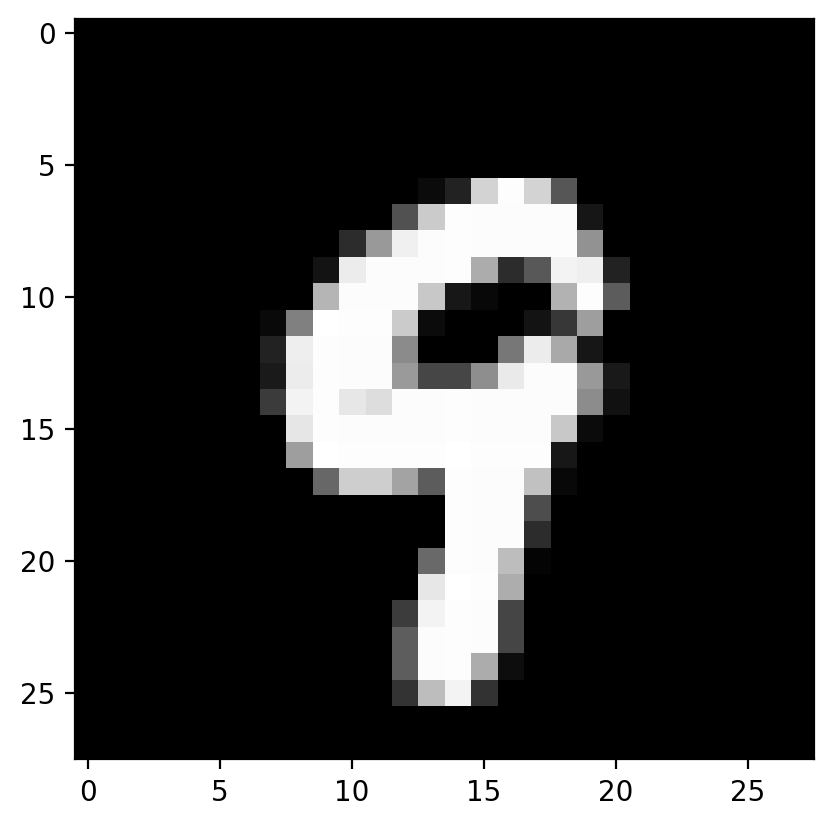

In [128]:
image, label = train_dataset[0]
plt.imshow(image, cmap="gray")
plt.show()

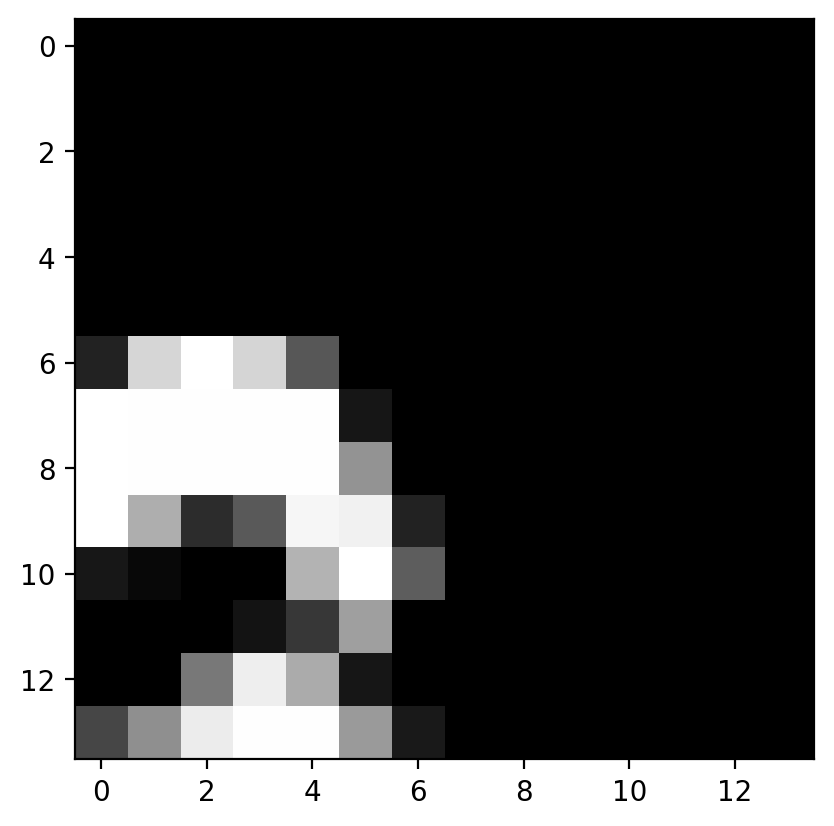

In [129]:
plt.imshow(image[:14, -14:], cmap="gray")

Вспомогательная функция для массовой визуализации:

In [130]:
def show_images_with_captions(images, captions=None, ncol=8):
    nrow = len(images) // ncol

    plt.figure(figsize=(16, 16 * nrow // ncol))
    for i in range(len(images)):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(images[i], cmap="gray")
        if captions is not None:
            plt.title(captions[i])
        plt.grid(False)
        plt.axis(False)
    plt.show()

In [131]:
sample_indices = np.random.choice(len(train_dataset), size=64, replace=False)

sample_images = []
sample_captions = []
for i in sample_indices:
    image, label = train_dataset[i]
    sample_images.append(image)
    sample_captions.append(f"gt: {label}")

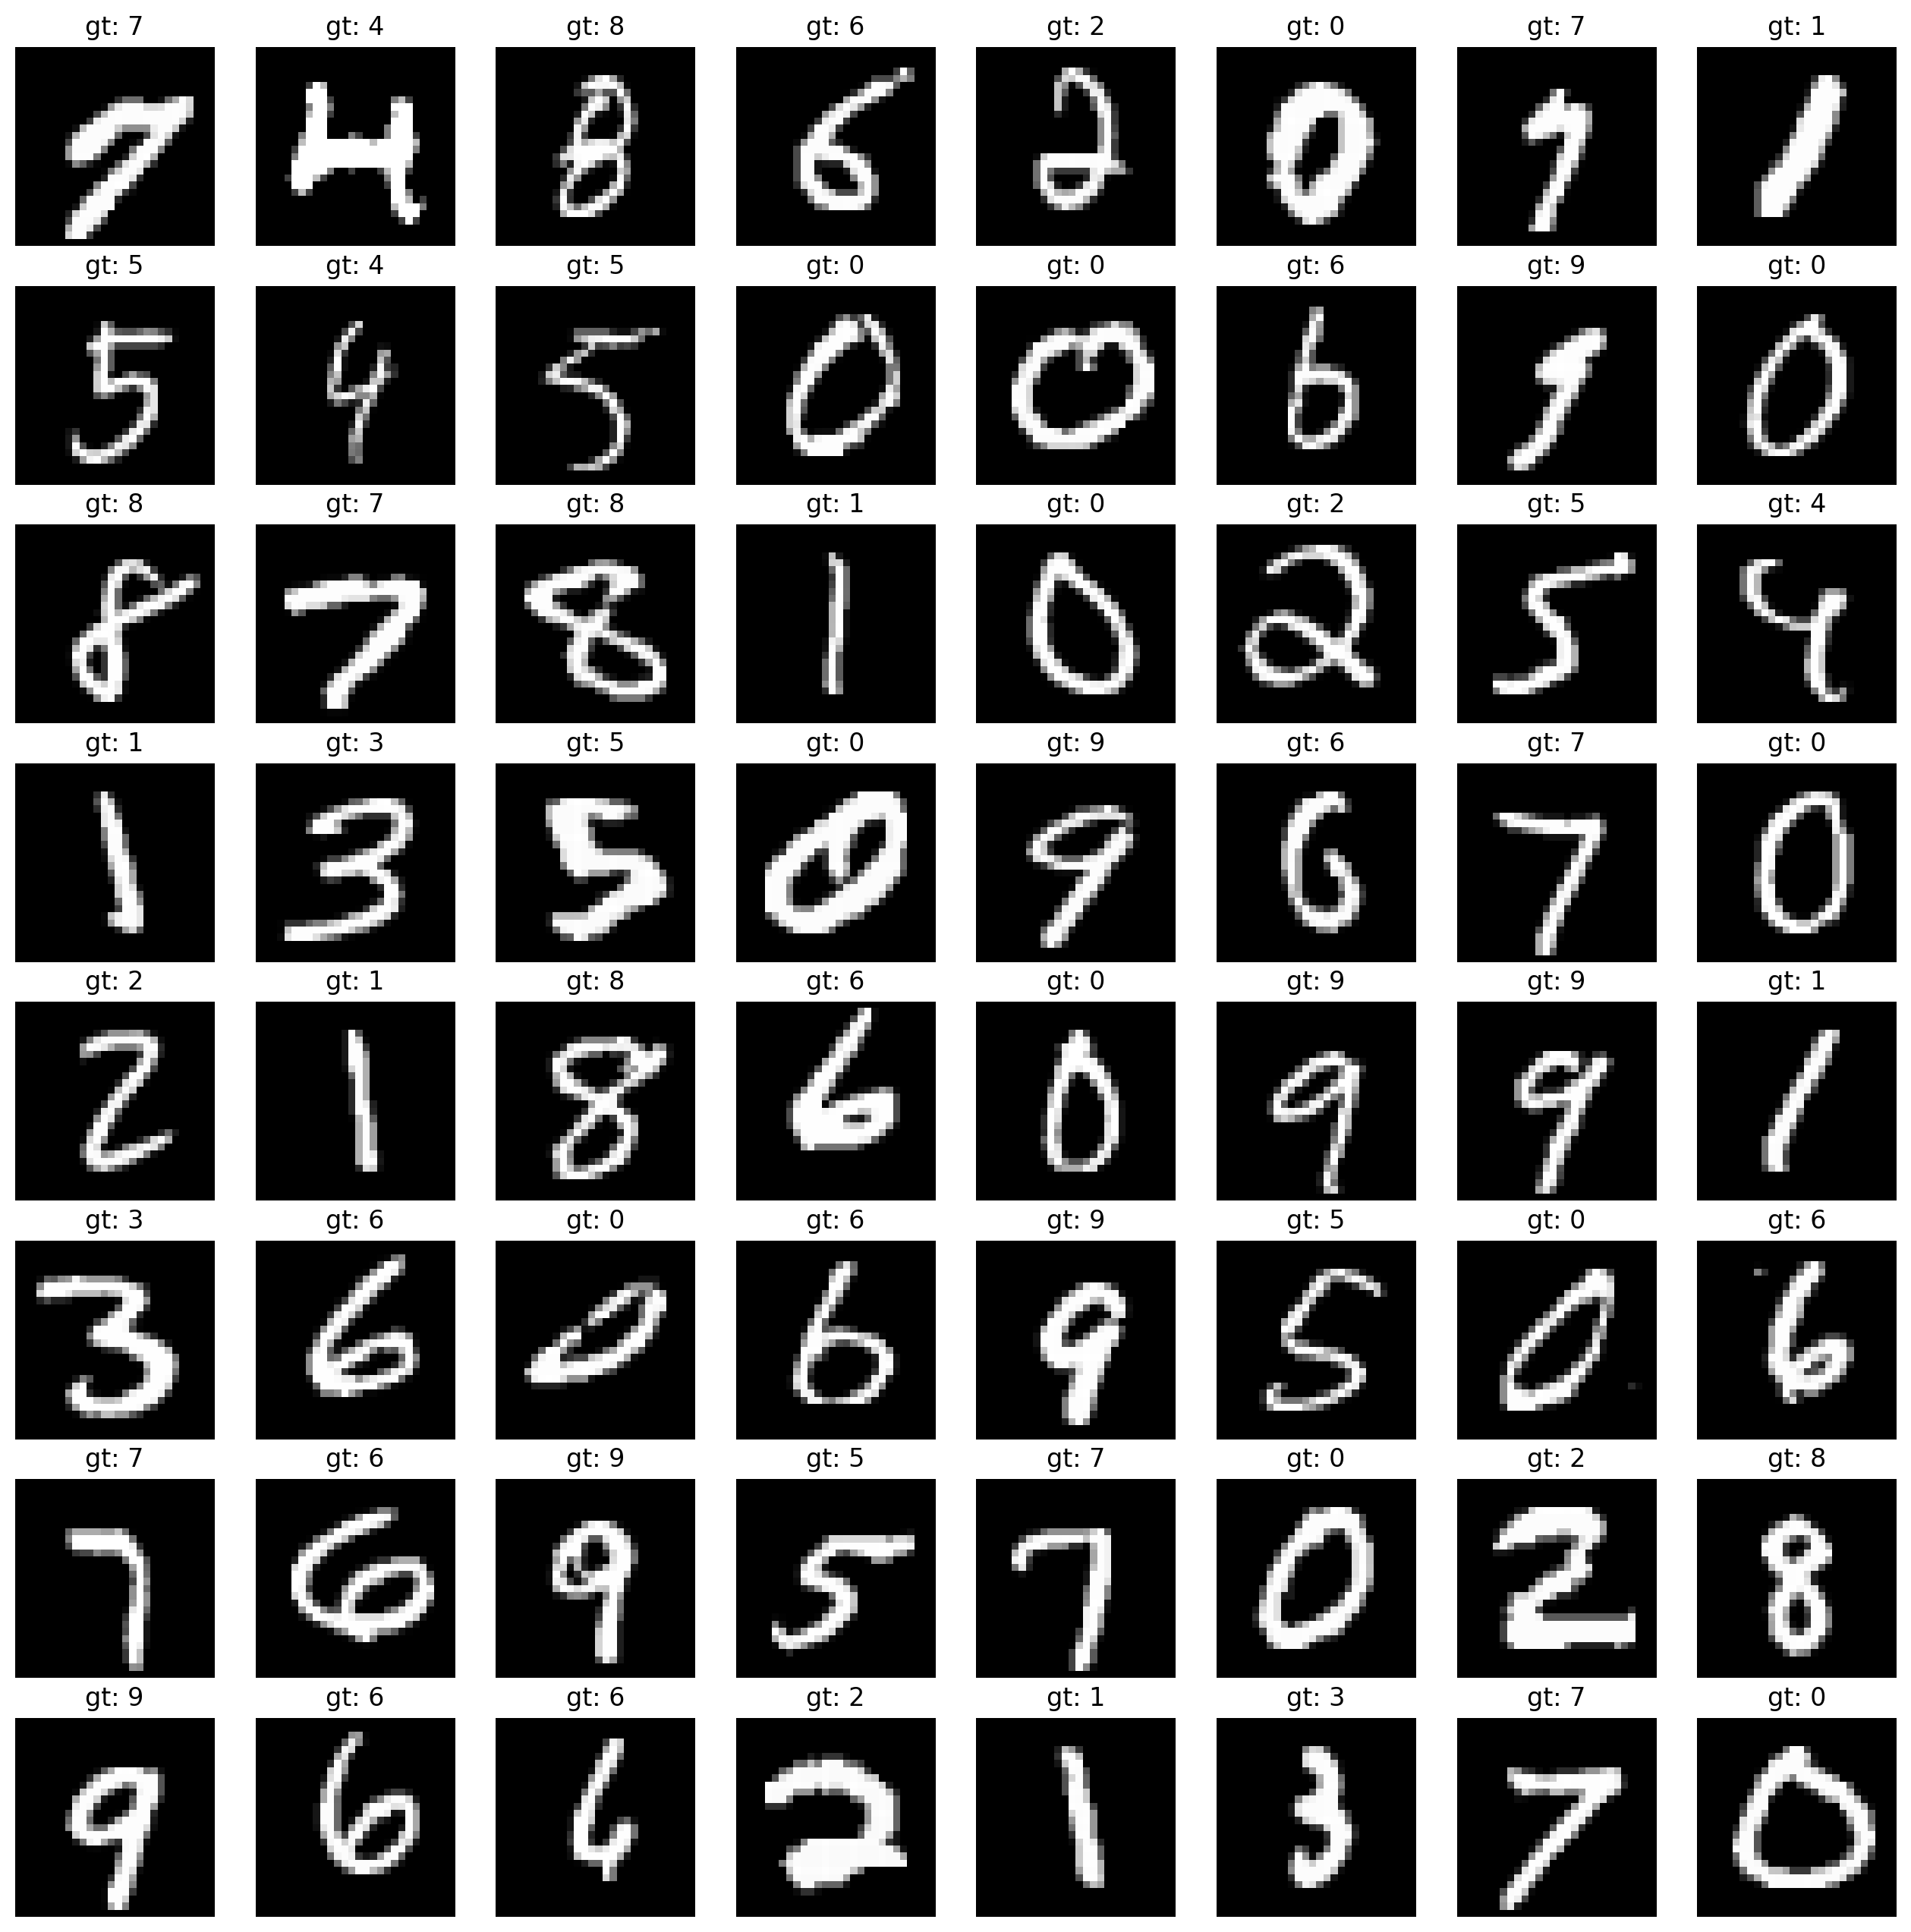

In [132]:
show_images_with_captions(sample_images, sample_captions)

Зарядим теперь обучение сети чуть глубже (3 слоя), да еще и с BatchNorm1d:

In [133]:
num_epochs = 5
batch_size = 100
lr = 3e-4

# device = torch.device("cpu")
device = torch.device("mps")
# device = torch.device("cuda:0")

In [134]:
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=train_dataset.collate_fn
)

val_dataset = MNISTDataset(root_dir="mnist_png/testing/")
val_dataloader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=train_dataset.collate_fn
)

In [135]:
model = Sequential(
    CustomLinear(28 * 28, 512),
    nn.BatchNorm1d(512),
    ReLU(inplace=True),
    CustomLinear(512, 1024),
    nn.BatchNorm1d(1024),
    ReLU(inplace=True),
    CustomLinear(1024, 10),
).to(device)

In [136]:
optimizer = optim.Adam(model.parameters(), lr=lr)

Лосс возьмем готовый, свой напишете дома:

In [137]:
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss()

Функции для обучения / валидации возьмем те же, что и раньше - пока сгодятся:

In [138]:
losses = []
val_losses = []
val_preds = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)

    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)
    val_preds.append(preds)

100%|██████████| 5/5 [01:10<00:00, 14.14s/it]


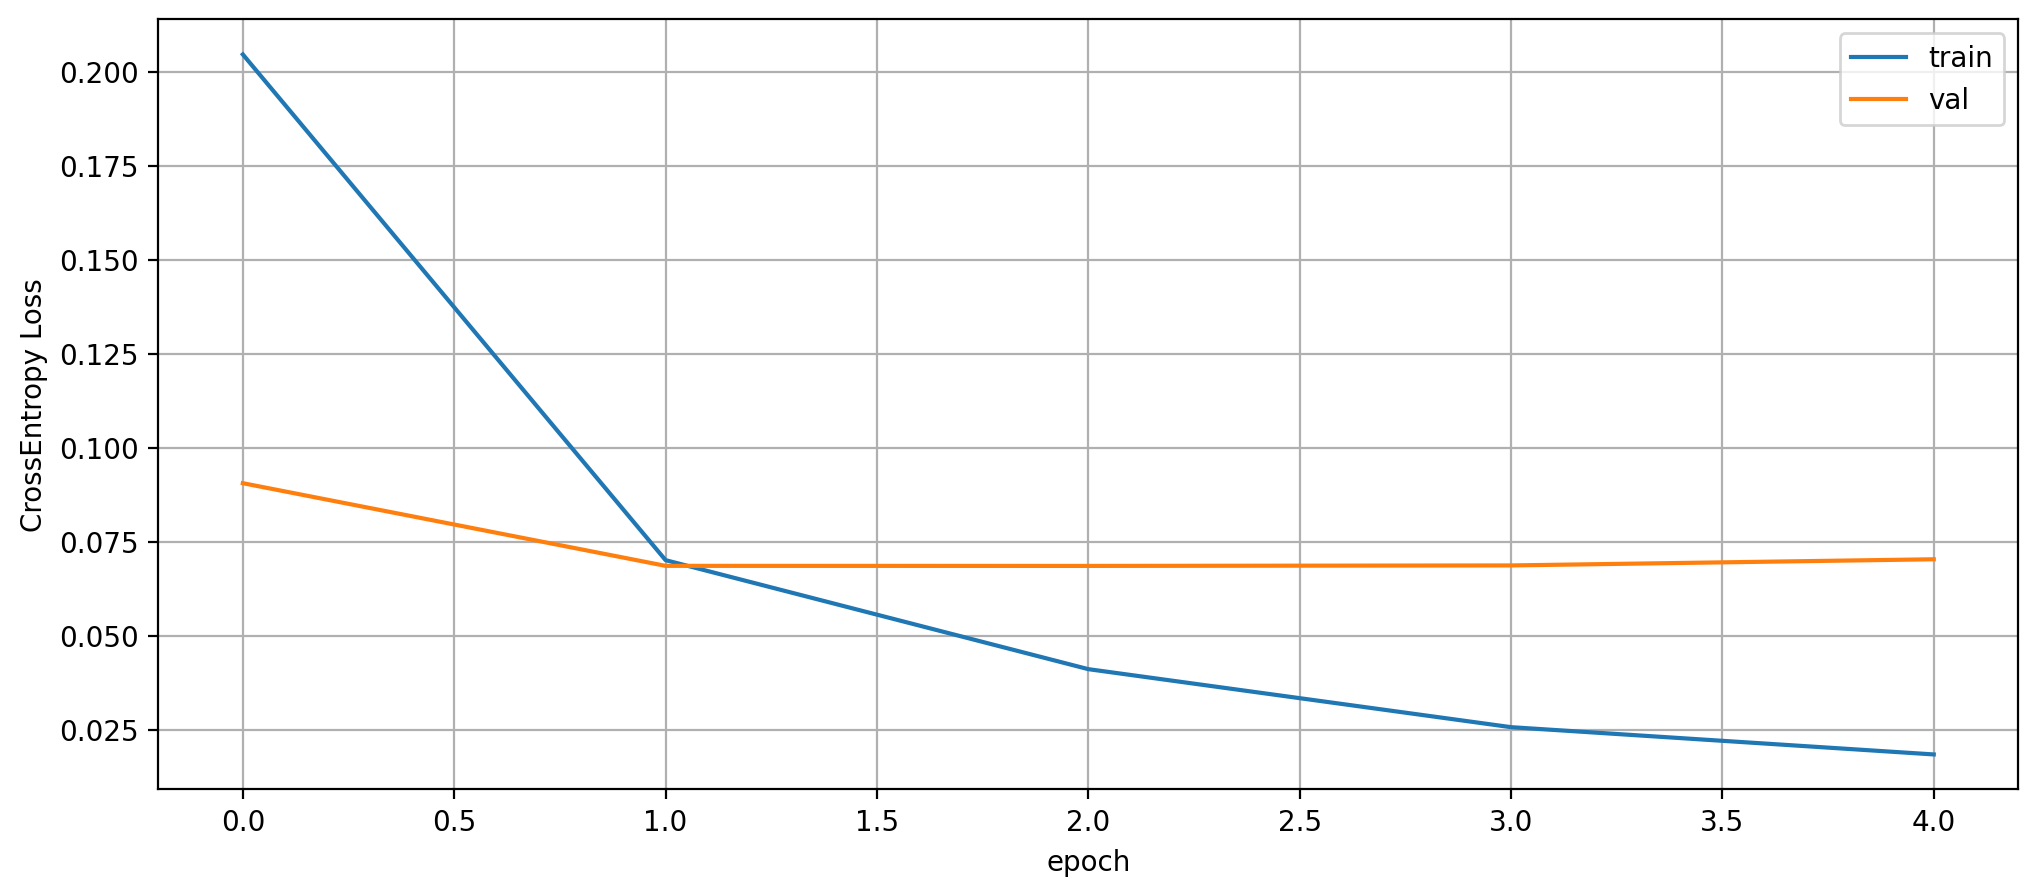

In [139]:
plt.figure(figsize=(12, 5))
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("epoch")
plt.ylabel("CrossEntropy Loss")
plt.legend()
plt.grid()
plt.show()

Соберем все предсказания / gt-лейблы, чтобы посчитать метрику Accuracy и сделать визуализацию:

In [140]:
val_pred_labels = []
for val_pred in val_preds[-1]:
    pred_label = np.argmax(val_pred)
    val_pred_labels.append(pred_label)
val_pred_labels = np.asarray(val_pred_labels)

In [141]:
val_labels = []
for image, label in val_dataset:
    val_labels.append(label)
val_labels = np.asarray(val_labels)

In [142]:
acc = (val_pred_labels == val_labels).mean()
acc

0.9773

In [143]:
sample_indices = np.random.choice(len(val_dataset), size=64, replace=False)

sample_images = []
sample_captions = []
for i in sample_indices:
    image, label = val_dataset[i]
    pred_label = val_pred_labels[i]
    sample_images.append(image)
    sample_captions.append(f"gt: {label} | pred: {pred_label}")

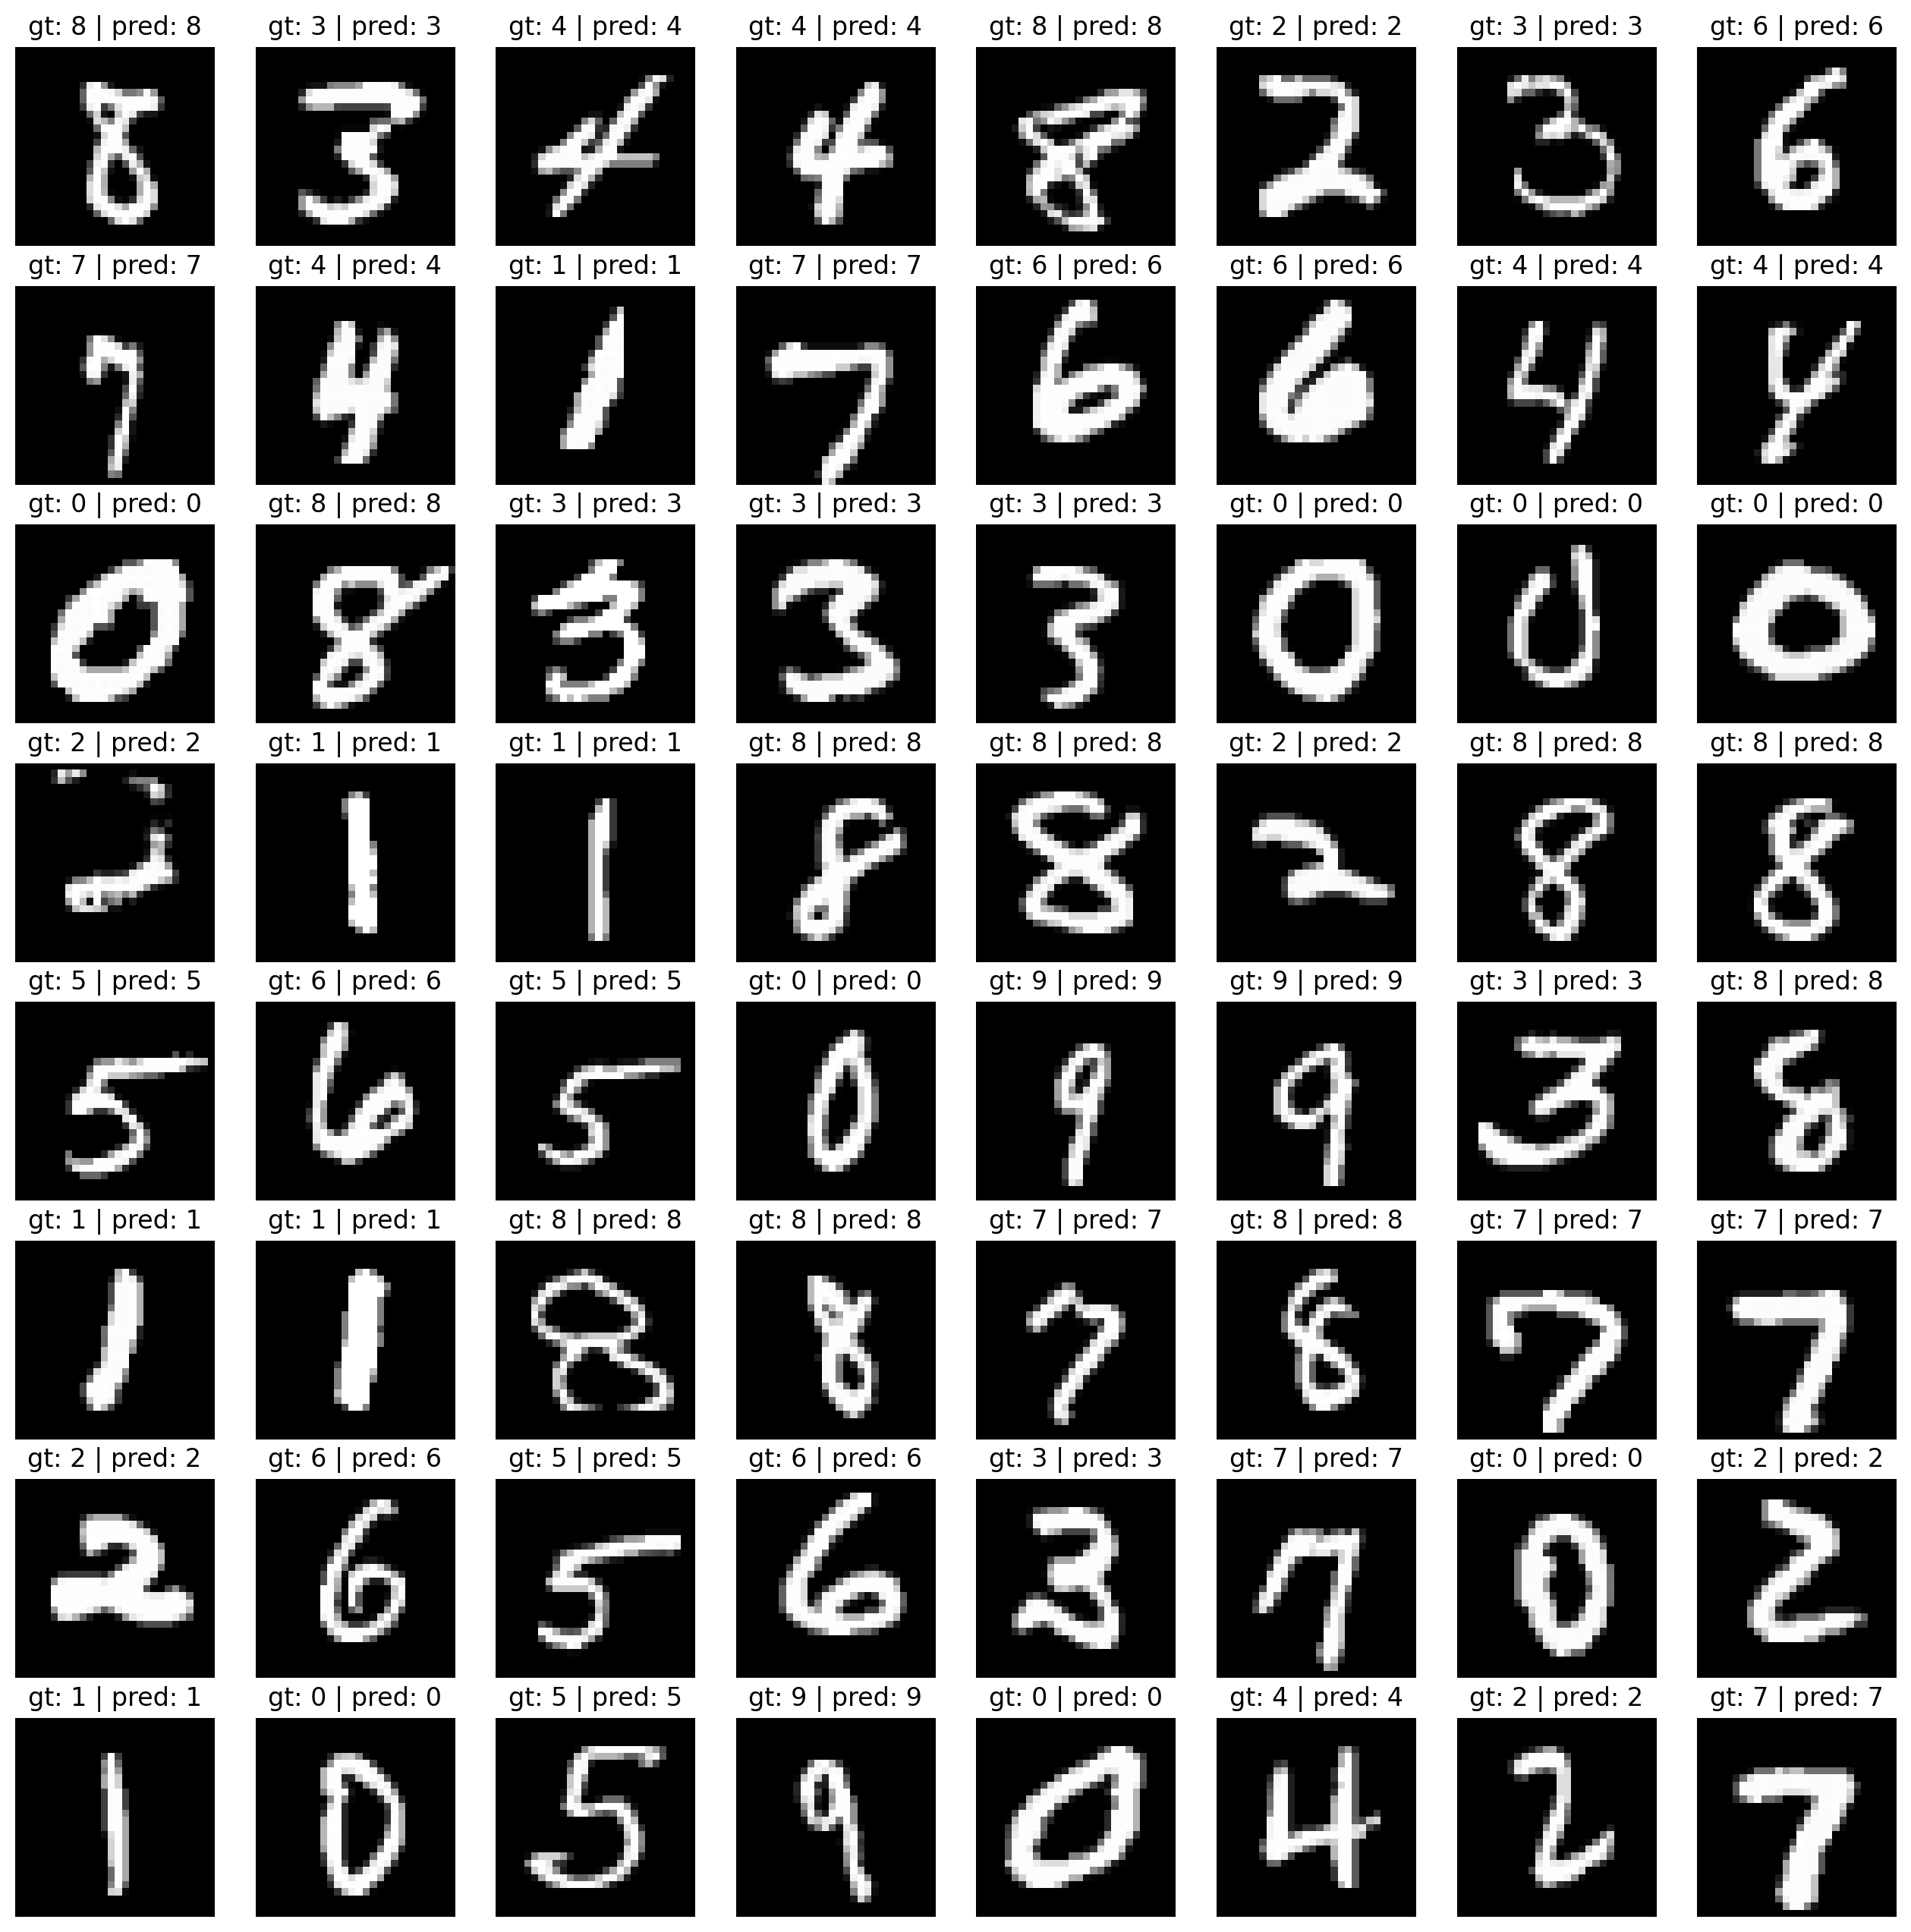

In [144]:
show_images_with_captions(sample_images, sample_captions)

Можем отдельно отрисовать те примеры из валидации, на которых модель ошибается:

In [145]:
sample_indices = np.random.choice(np.where(val_labels != val_pred_labels)[0], size=64, replace=False)

sample_images = []
sample_captions = []
for i in sample_indices:
    image, label = val_dataset[i]
    pred_label = val_pred_labels[i]
    sample_images.append(image)
    sample_captions.append(f"gt: {label} | pred: {pred_label}")

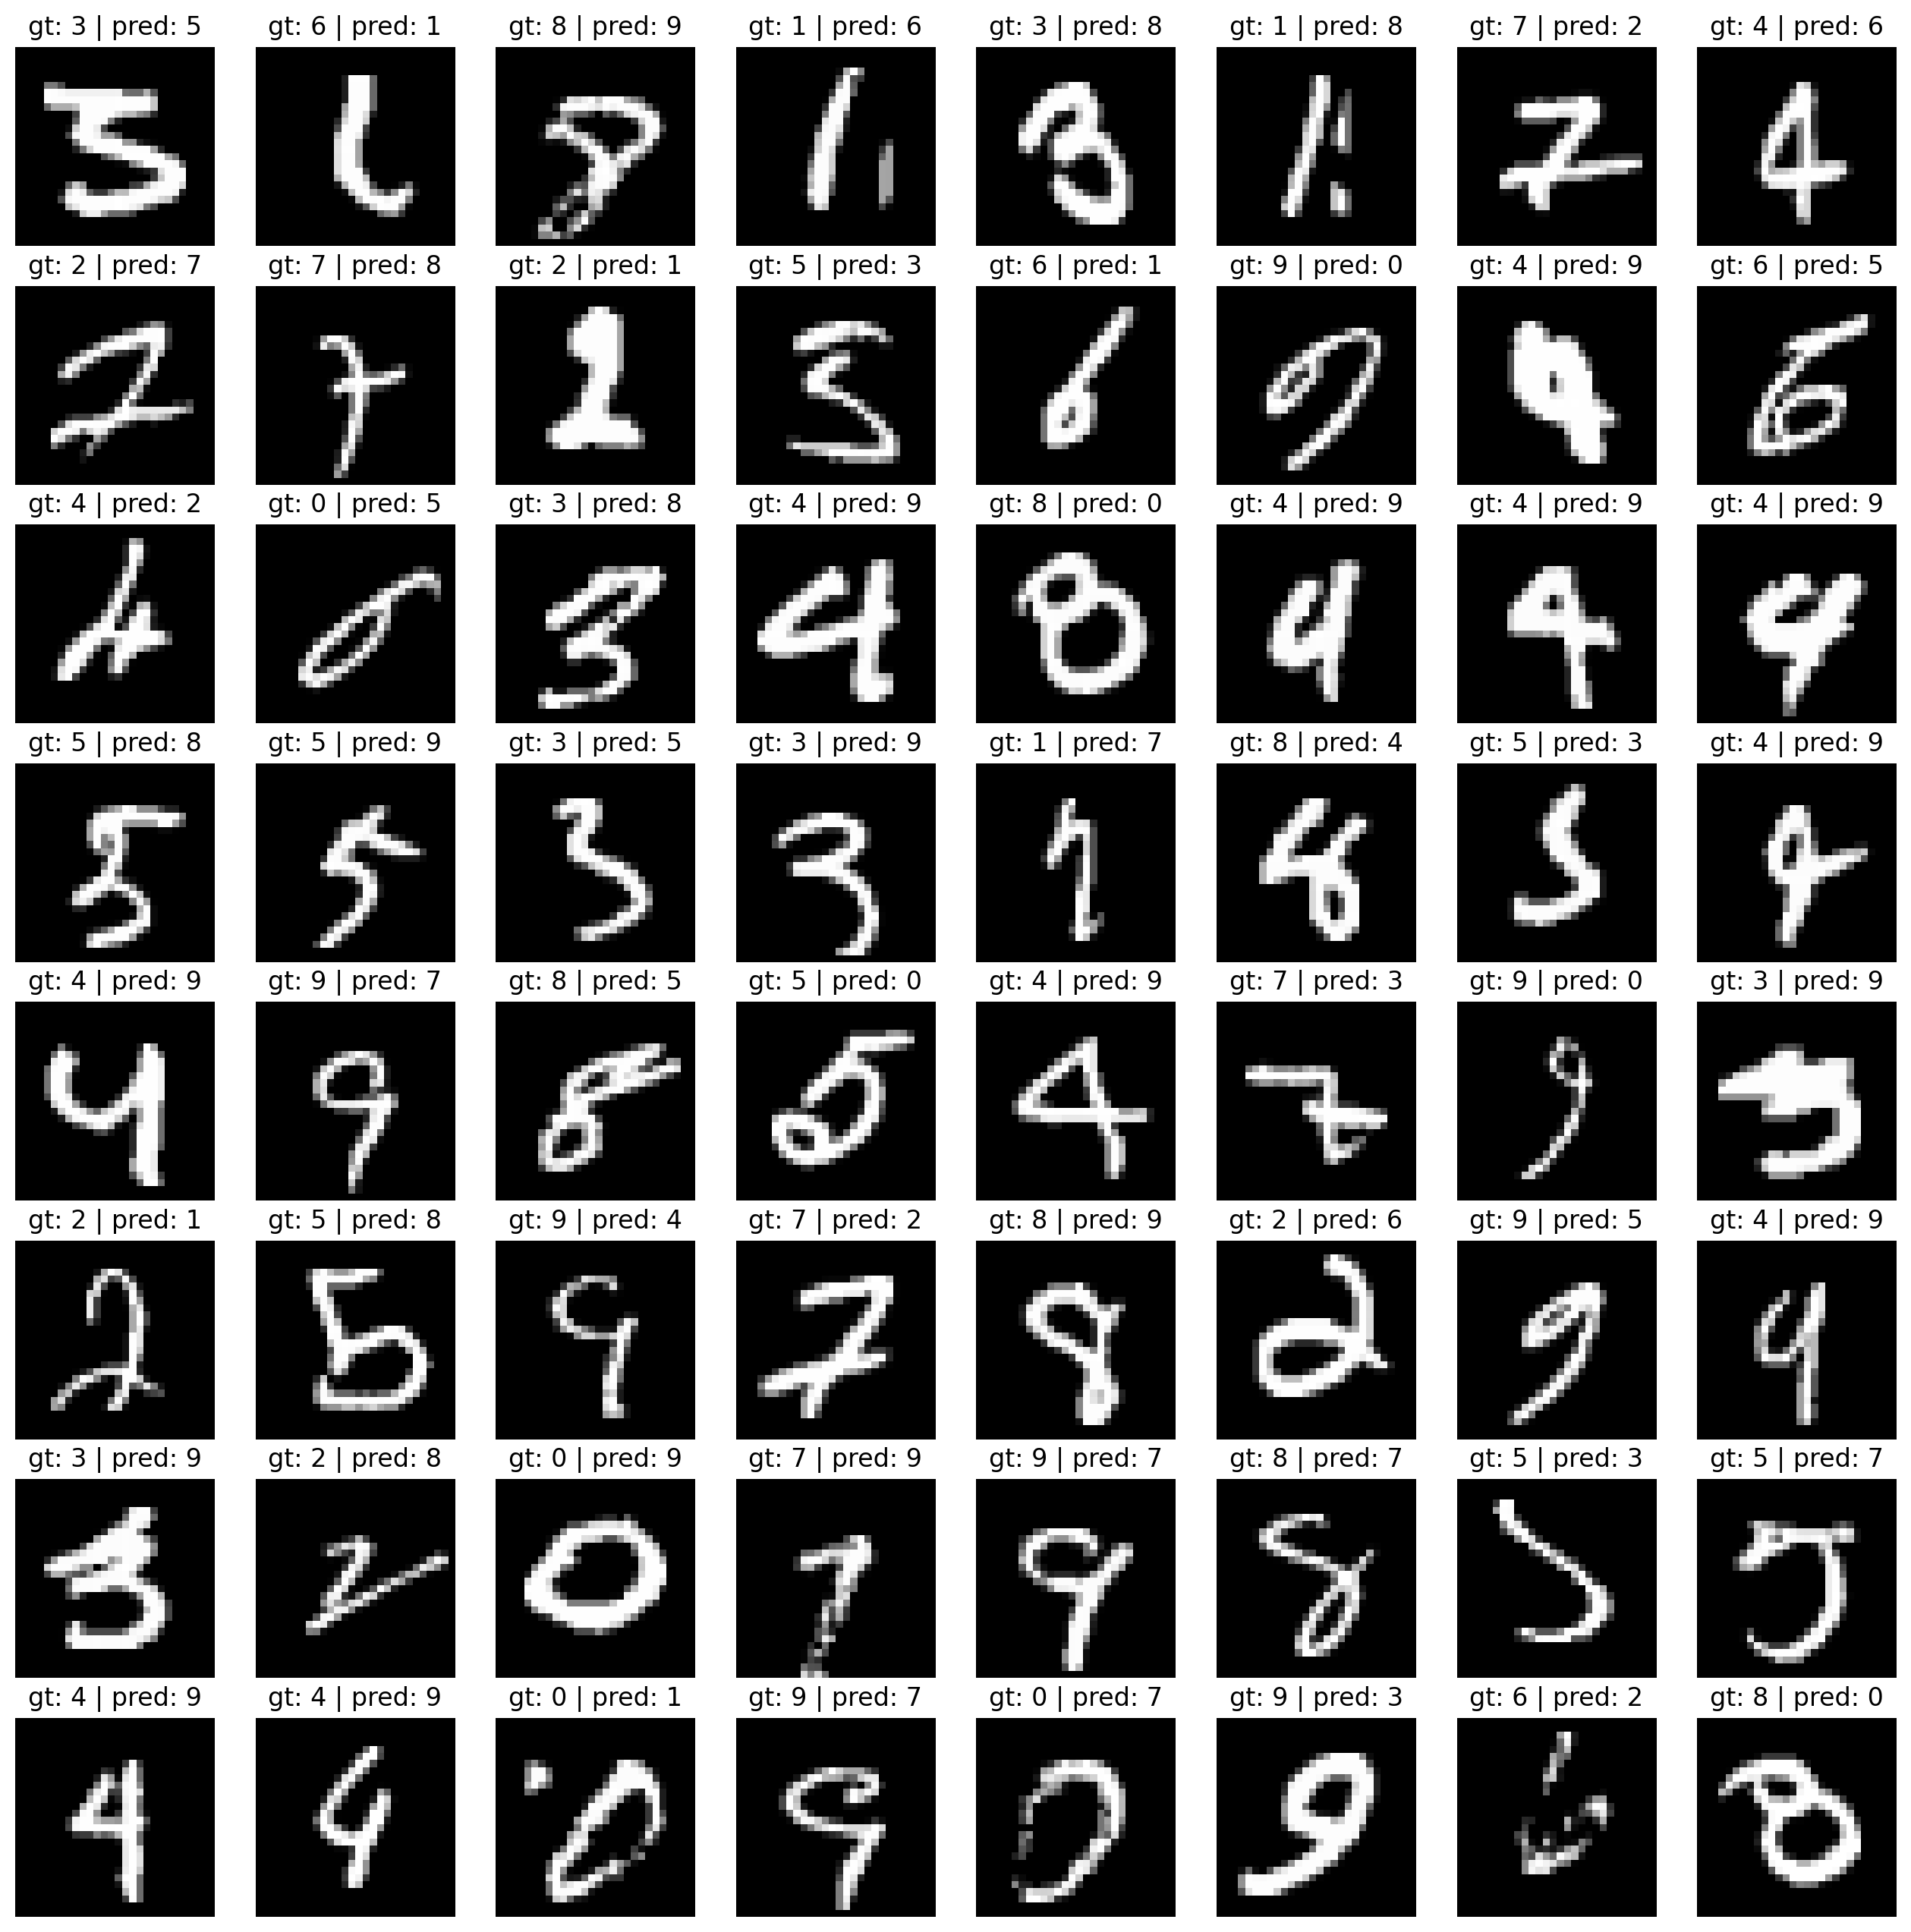

In [146]:
show_images_with_captions(sample_images, sample_captions)

## Итоги

* Узнали, какие есть базовые сущности в Pytorch для обучения нейросетей
* Реализовали собственные классы датасета и модели
* Написали собственную функции активации и даже `backward()` для нее

В следующий раз: 
* Свертки и сверточные сети